In [22]:
!pip install requirements.txt

HINT: You are attempting to install a package literally named "requirements.txt" (which cannot exist). Consider using the '-r' flag to install the packages listed in requirements.txt


ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
ERROR: No matching distribution found for requirements.txt

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# make sure to install appropriate PyTorch version
# https://pytorch.org/get-started/locally/
# Versions used to develop this notebook:
# torch                                    2.3.1+cu118
# torchaudio                               2.3.1+cu118
# torchvision                              0.18.1+cu118

In [1]:
import pandas as pd
import numpy as np
import torch 
from fredapi import Fred
import matplotlib.pyplot as plt
import yaml
import seaborn as sns
from pathlib import Path
import mlflow
import os
from scipy.stats import boxcox
from torch import optim
import torch.nn as nn
from statsmodels.graphics.tsaplots import plot_acf
import warnings

In [2]:
warnings.filterwarnings("ignore")

### Forecasting monetary policy variables using deep learning and monetary policy theory.

In [35]:
# Pytorch settings
scaling_mode = "standard"
batch_size = 4
seq_length = 3
random_seed = 1
torch.manual_seed(random_seed)
log_interval = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_folder = Path("./models")
plt.style.use('fivethirtyeight')
print(device)

cuda:0


In [27]:
# MLflow settings
uri = "http://127.0.0.1:5000/"
mlflow.set_tracking_uri(uri)
# launch server using "mlflow server --host 127.0.0.1 --port 8080" in a terminal

Central bank aims to minimize:
$L_t = E_t\left[\frac{1}{2}(U_t - \tilde{U})^2 +  \frac{1}{2}\theta(\pi_t - \tilde{\pi})^2\right]$
By choosing $U_t$ and $\pi_t$ such that $U_t = -(\pi_t - \pi^e_t)$.
Where $U_t$ is unemployment, $\tilde{U}, \tilde{\pi}$ are socially optimal levels of unemployment and inflation, and $\pi^e$ are inflation expectations.
Which we can use the fisher equation $r_t = i_t -\pi_t$ so that central banks can use $i$ to influence inflation and hence unemployment.
With this, we will model these variables by just using unemployment, inflation, and Federal Funds Effective Rate.

### FRED data setup

In [75]:
%%writefile configs/time_series_config.yaml
FRED:
    CPIAUCSL:
        name: CPI
        log: True
        diff: true
        n_diffs: 1
        diff_name: log_inflation_MoM
    FEDFUNDS:
        name: fed_rate
        log: False
        diff: true
        n_diffs: 1
    UNRATE:
        name: Unemployment
        log: false
        diff: true
        n_diffs: 1

Overwriting configs/time_series_config.yaml


In [76]:
path = "./params"
os.makedirs(path, exist_ok=True)
os.makedirs("./models", exist_ok=True)

In [77]:
def get_fred_api_key(path):
    with open(path, 'r') as f:
        key = f.read()
        return key

    
def get_data_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
        return config
        
config_path = Path("./configs")

key = get_fred_api_key(config_path / "fred_key.txt")
fred = Fred(api_key=key)

configs = get_data_config(config_path / "time_series_config.yaml")
fred_data = configs["FRED"]

def get_data(fred_data):
    data = {fred_data[code].get('name'): fred.get_series_latest_release(code) for code in fred_data}
    return pd.DataFrame(data)
    

data = get_data(fred_data)
print(data.shape)
print(data.describe())
data.tail(15)

(937, 3)
              CPI    fed_rate  Unemployment
count  937.000000  847.000000    925.000000
mean   121.730740    4.609020      5.681622
std     87.287108    3.565496      1.708949
min     21.480000    0.050000      2.500000
25%     32.450000    1.825000      4.400000
50%    109.000000    4.290000      5.500000
75%    194.900000    6.155000      6.700000
max    319.086000   19.100000     14.800000


CPI  fed_rate  Unemployment
2023-11-01  308.087      5.33           3.7
2023-12-01  308.735      5.33           3.8
2024-01-01  309.794      5.33           3.7
2024-02-01  311.022      5.33           3.9
2024-03-01  312.107      5.33           3.9
2024-04-01  313.016      5.33           3.9
2024-05-01  313.140      5.33           4.0
2024-06-01  313.131      5.33           4.1
2024-07-01  313.566      5.33           4.2
2024-08-01  314.131      5.33           4.2
2024-09-01  314.851      5.13           4.1
2024-10-01  315.564      4.83           4.1
2024-11-01  316.449      4.64           4.2
2024-12-01  317.603      4.48           4.1
2025-01-01  319.086      4.33           4.0

In [78]:
# Create a function to make data stationary
def difference_data(df, config):
    for item in config:
        series = config[item]
        col = series['name']
        
        try:
            diff_name = series['diff_name'] 
        except Exception:
            diff_name = col + "_diff"
        
        if series['log'] and series['diff']:
            
            df[diff_name] =  np.log(df[col])
            for i in range(series["n_diffs"]):
                df[diff_name] = df[diff_name].diff()
                
        elif series['diff']:
            df[diff_name] = df[col]
            for i in range(series["n_diffs"]):
                df[diff_name] = df[diff_name].diff()
                #print(df[diff_name].tail(20))

    return df.dropna()

data_diff = difference_data(data, fred_data)
print(data_diff.tail())
# Instantaneous correlations 
# Example explanation of correlations assuming a postive aggregate demand shock:
# If inflation is high then Fed effective rate is most likely high currently or will increase 
# in the same period.
# If unemployment is low then firms are hiring lots of labour to produce lots of output to 
# meet the demand causing higher wage pressure and hence inflation hence the
# negative correlations between unemployment and log_inflation.
print("\nInstantaneous correlations:\n",data_diff.corr())

                CPI  fed_rate  Unemployment  log_inflation_MoM  fed_rate_diff  \
2024-09-01  314.851      5.13           4.1           0.002289          -0.20   
2024-10-01  315.564      4.83           4.1           0.002262          -0.30   
2024-11-01  316.449      4.64           4.2           0.002801          -0.19   
2024-12-01  317.603      4.48           4.1           0.003640          -0.16   
2025-01-01  319.086      4.33           4.0           0.004658          -0.15   

            Unemployment_diff  
2024-09-01               -0.1  
2024-10-01                0.0  
2024-11-01                0.1  
2024-12-01               -0.1  
2025-01-01               -0.1  

Instantaneous correlations:
                         CPI  fed_rate  Unemployment  log_inflation_MoM  \
CPI                1.000000 -0.397182     -0.014987          -0.151367   
fed_rate          -0.397182  1.000000      0.063278           0.495915   
Unemployment      -0.014987  0.063278      1.000000           0.00009

In [79]:
# Look at lagged correlations
correlations = []
lagged = data_diff.copy()
for lag in range(1, 16):
    lagged.loc[:, f"fed_rate_diff_lagged_{lag}"] = lagged["fed_rate_diff"].shift(lag) 
    corr = lagged.corr().loc[["Unemployment_diff", "log_inflation_MoM"], f"fed_rate_diff_lagged_{lag}"].values
    correlations.append(corr)
# As we see, the corrlelations between the lagged differenced effective funds rate and the other differenced series
# get smaller.
frame = pd.DataFrame(correlations).T
frame.index = ["Unemployment_diff", "log_inflation_MoM"]
frame.columns.name = "Lag"
frame.columns += 1

# We see that an increase in the effective rate today will contribute to incresed unemployment over time.
# And log inflation correlation weakens and eventually turns negative which the effect of a
# rate change takes time due to nominal rigidities.
frame

Lag                      1         2         3         4         5         6   \
Unemployment_diff -0.100205 -0.029052 -0.038175 -0.008699 -0.008175 -0.009777   
log_inflation_MoM  0.140183  0.162008  0.119405  0.084021  0.083149  0.072723   

Lag                      7         8         9         10        11        12  \
Unemployment_diff  0.019275 -0.016206  0.027026  0.030779  0.035809  0.018058   
log_inflation_MoM  0.078078  0.090544  0.058560  0.081837  0.088885  0.107302   

Lag                      13        14        15  
Unemployment_diff  0.026247  0.041635  0.033820  
log_inflation_MoM  0.092879  0.061295  0.055164

### Plot the transformed time series

<Axes: >

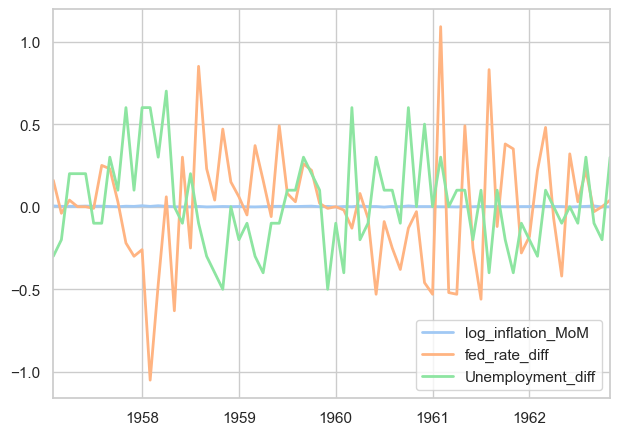

In [80]:
data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].iloc[30:100].plot(linewidth=2)

<Axes: >

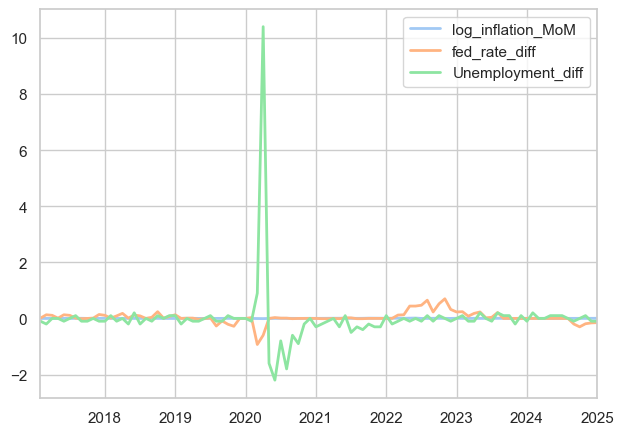

In [81]:
data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].iloc[750:].plot(linewidth=2)

### Undifferenced time series

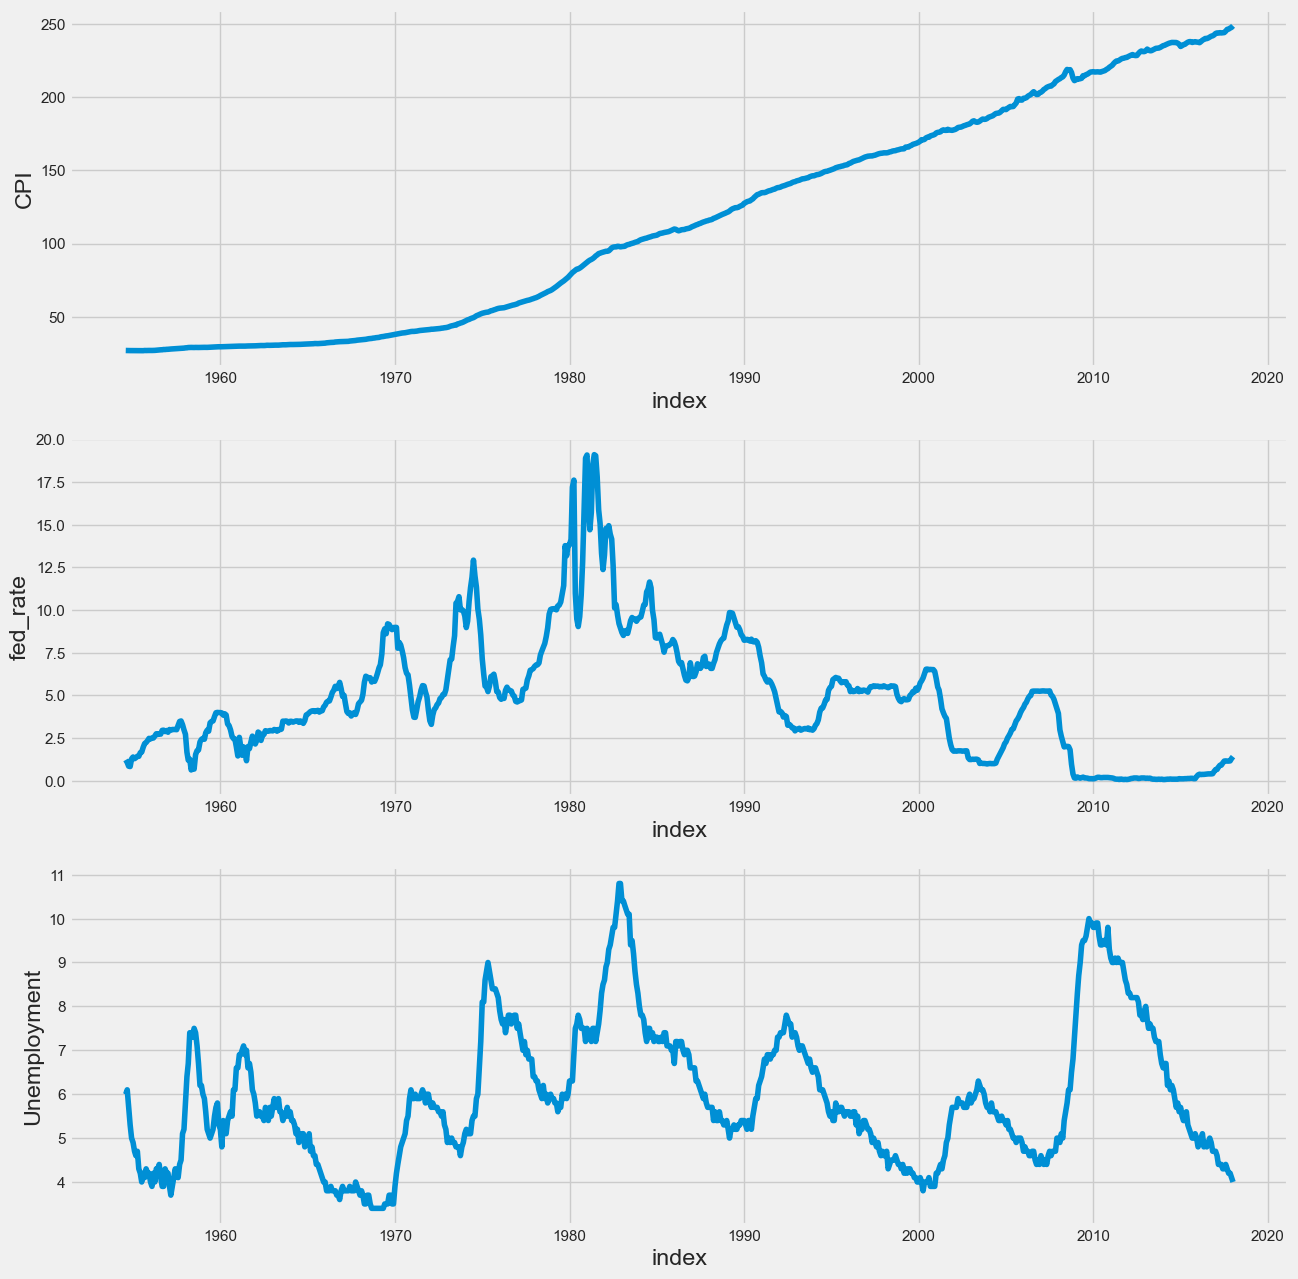

In [82]:
# Plot undifferenced data
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(3,1, figsize=(14,15))
for i, series in enumerate(["CPI", "fed_rate", "Unemployment"]):
    g = sns.lineplot(
        data=data_diff.loc[:"2018-01-01",["CPI", "fed_rate", "Unemployment"]].reset_index(),
        x="index", y=series, ax=axs[i],
    )

### Better plots of transformed time series.

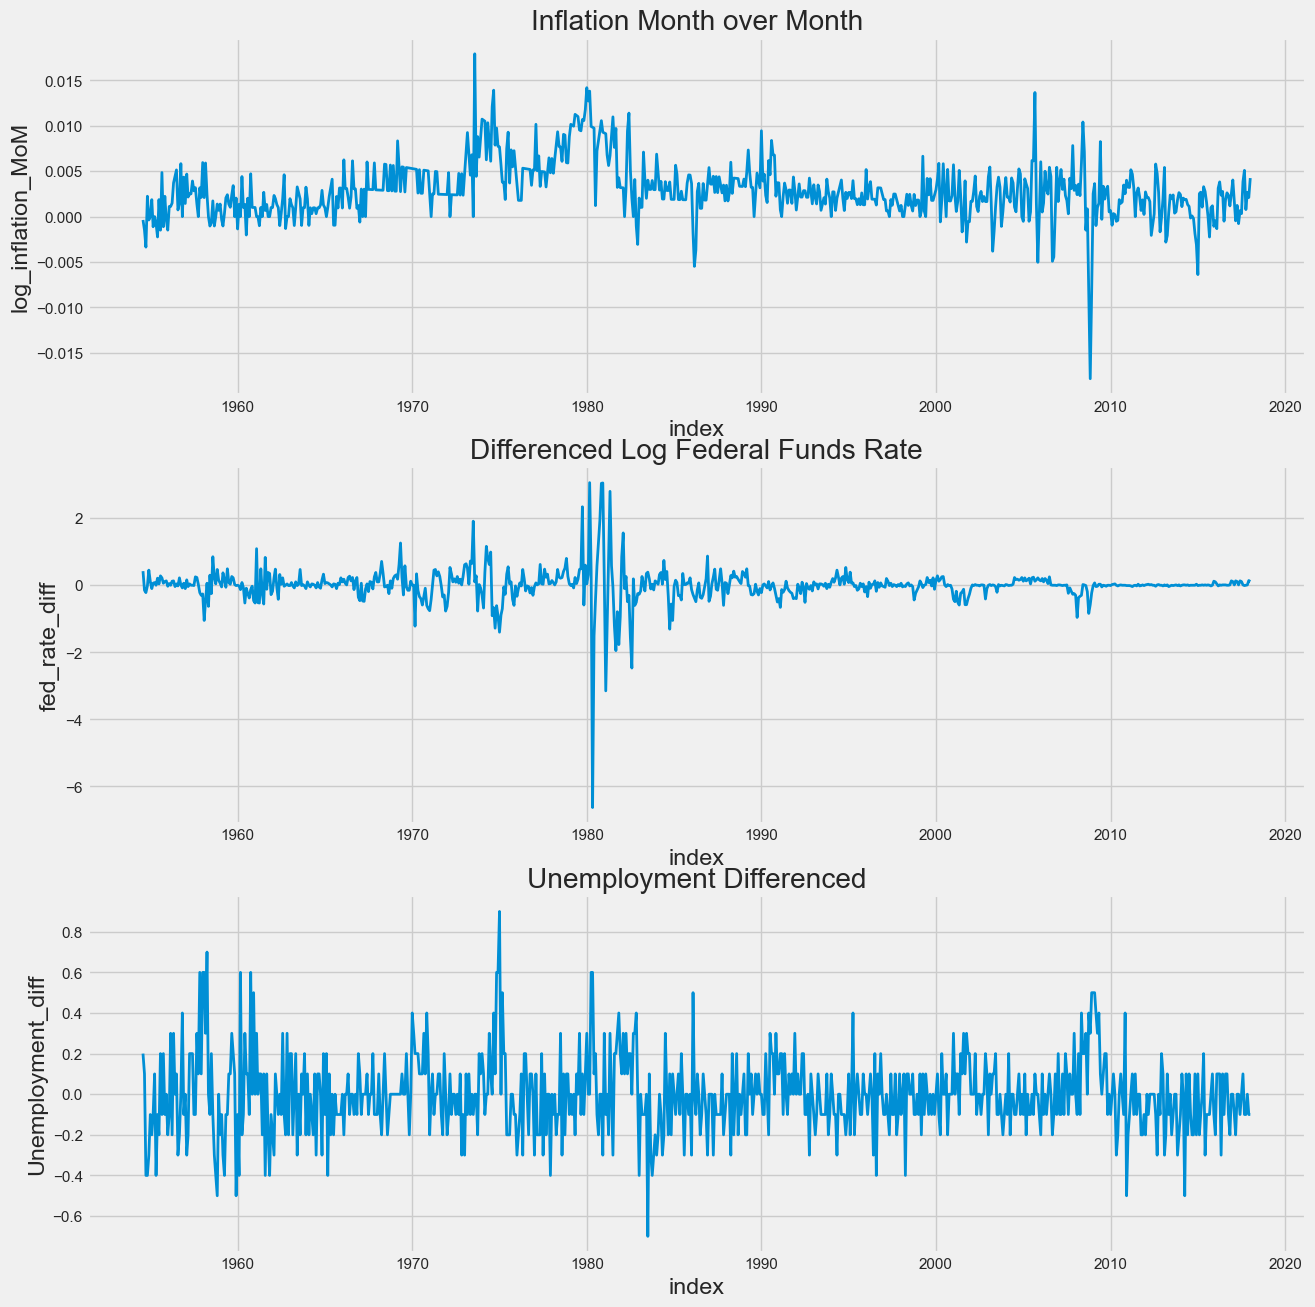

In [ ]:
fig, axs = plt.subplots(3,1, figsize=(14,15))
plt.style.use('fivethirtyeight')
series_names = {
    "log_inflation_MoM": "Inflation Month over Month",
    "fed_rate_diff": "Differenced Log Federal Funds Rate",
    "Unemployment_diff": "Unemployment Differenced",
}

for i, series in enumerate(["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]):
    axs[i].set_title(series_names[series])
    g = sns.lineplot(
        data=data_diff.loc[:"2018-01-01", ["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].reset_index(),
        x="index", y=series, ax=axs[i], linewidth=2
    )

# Clearly the variance of the inflation data variance is growing over time and hence not stationary.
# We also see the volcker inflation era where the mean shifted upward

### Season plots

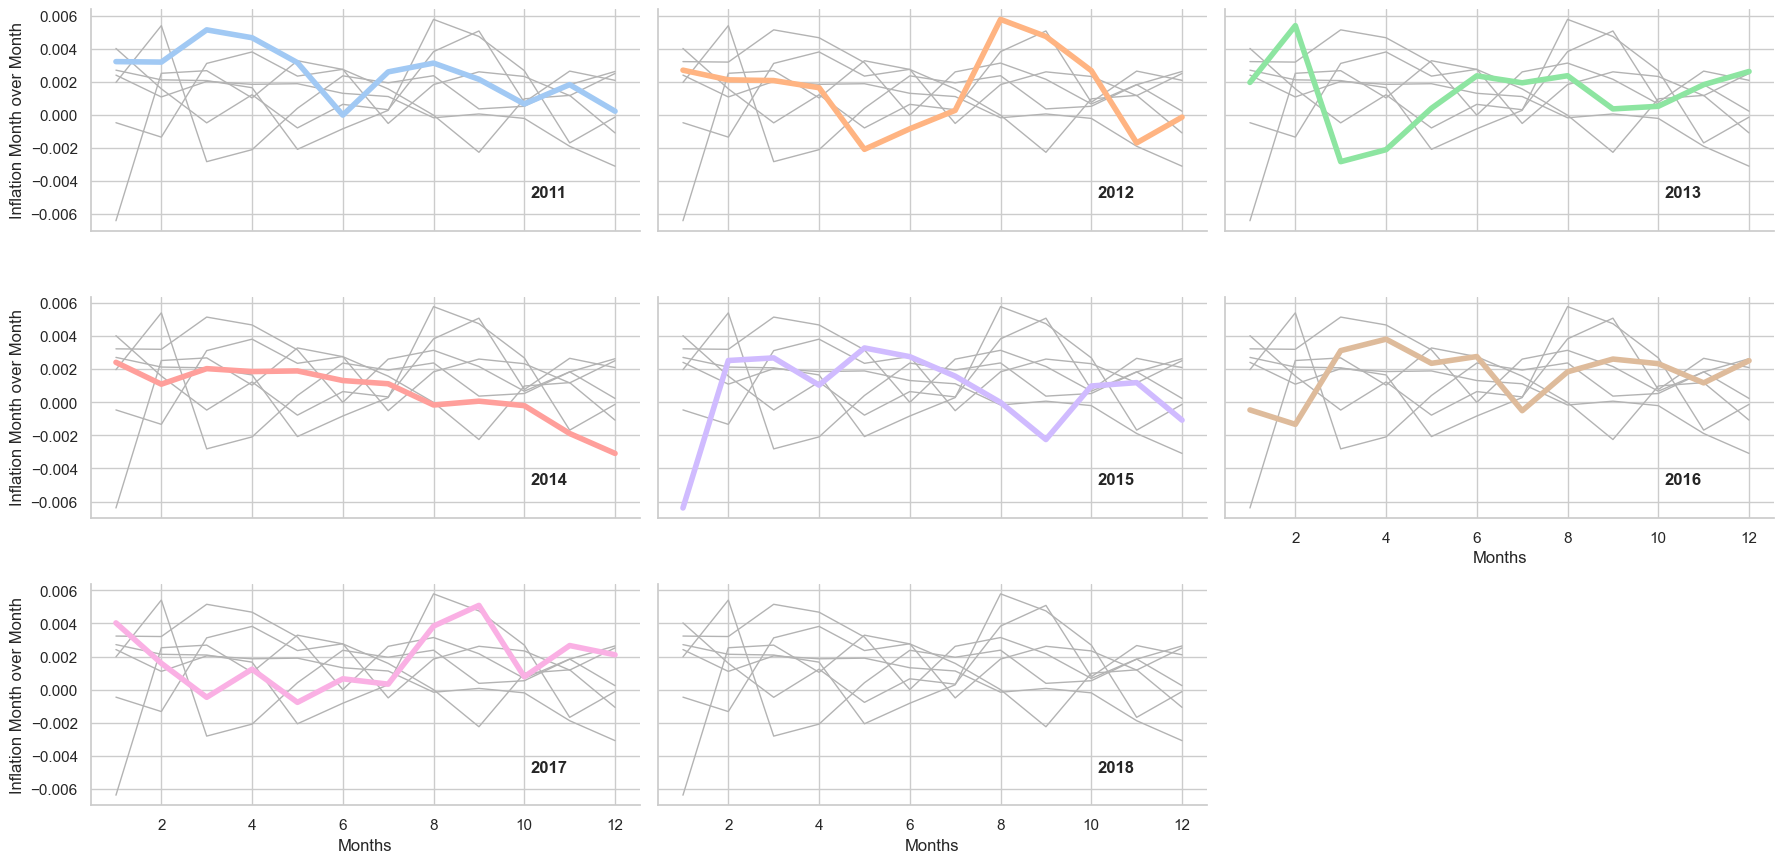

In [84]:
def monthly_facet_plot(data, var):
    data = data.copy()
    data.loc[:, "month"] = data.index.month
    data.loc[:, "year"] = data.index.year
    sns.set_theme(style="whitegrid", palette="pastel")
    
    g = sns.relplot(
        data=data,
        x="month", y=var, col="year", hue="year",
        kind="line", palette="pastel", linewidth=4, zorder=5,
        col_wrap=3, height=3, aspect=2, legend=False,
    )
    
    for year, ax in g.axes_dict.items():
        ax.set_title("")
        ax.text(.8, .15, year, transform=ax.transAxes, fontweight="bold")
    
        sns.lineplot(
            data=data, x="month", y=var, units="year",
            estimator=None, color=".7", linewidth=1, ax=ax,
        )
    g.set_axis_labels("Months", series_names[var])

data_window = data_diff["2011-01-01":"2018-01-01"]
monthly_facet_plot(data_window, "log_inflation_MoM")

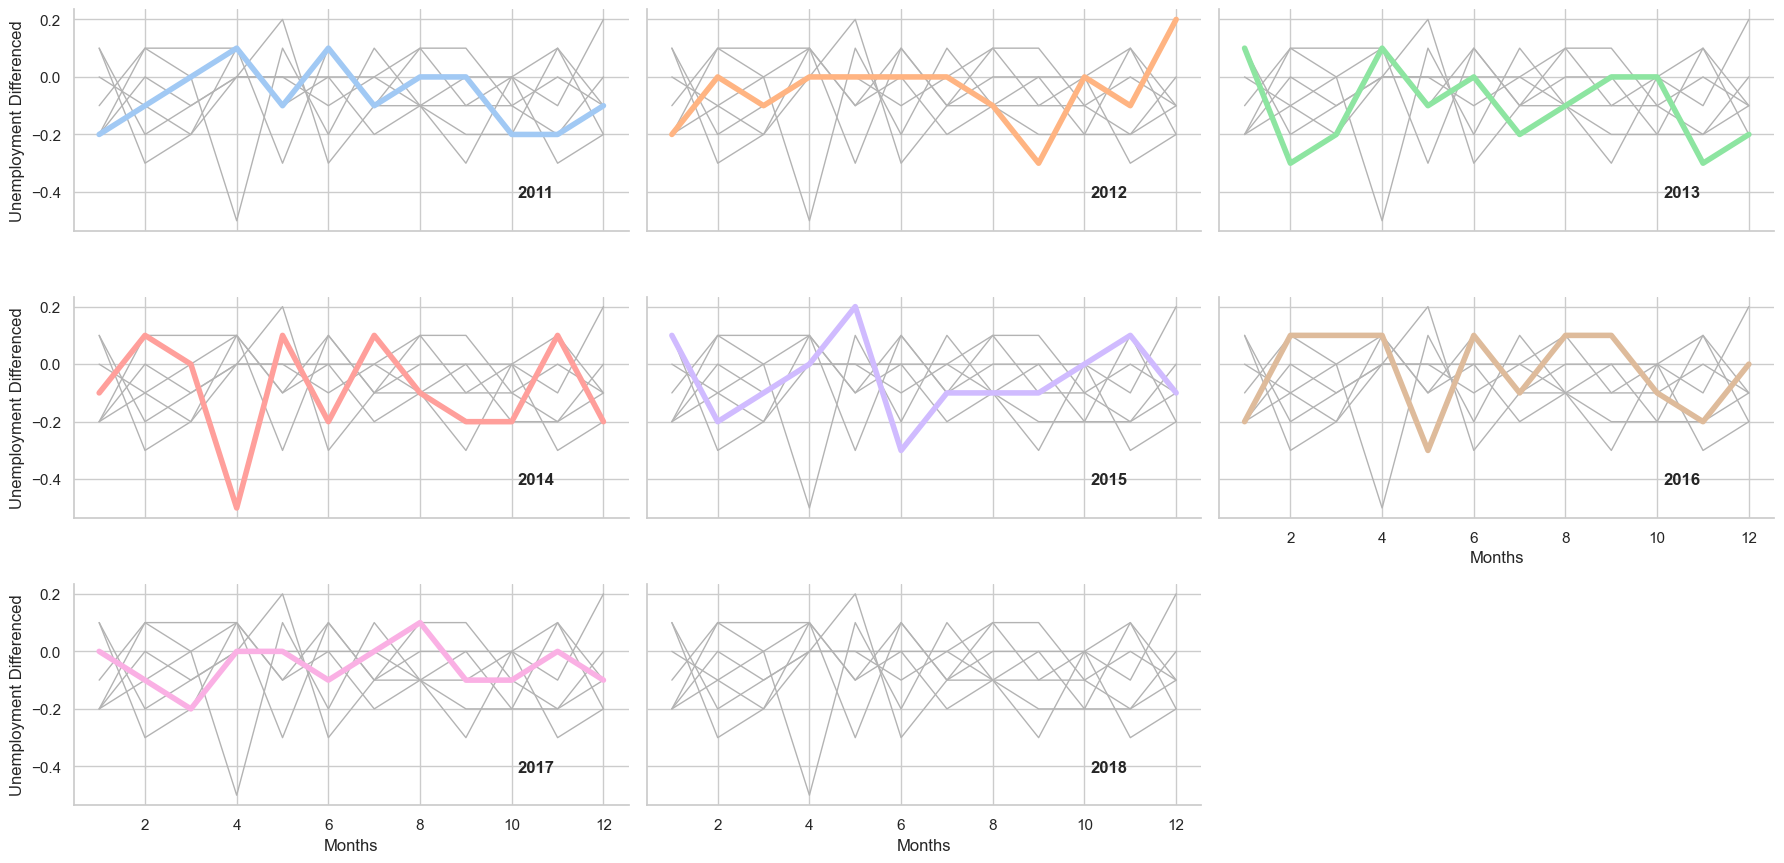

In [85]:
data_window = data_diff["2011-01-01":"2018-01-01"]
monthly_facet_plot(data_window, "Unemployment_diff")

In [86]:
# Create train and validation data cutoff dates
cutoff = int(data_diff.shape[0]*0.80)
print(cutoff)
validation_cutoff = int(cutoff*0.8)
print(validation_cutoff)

cutoff_date = str(data_diff.iloc[cutoff-1].name)
print("train+validation cutoff",cutoff_date)

validation_cutoff_date = str(data_diff.iloc[validation_cutoff-1].name)
print("validation cutoff", validation_cutoff_date)

676
540
train+validation cutoff 2010-11-01 00:00:00
validation cutoff 1999-07-01 00:00:00


## Time series stationary assesment

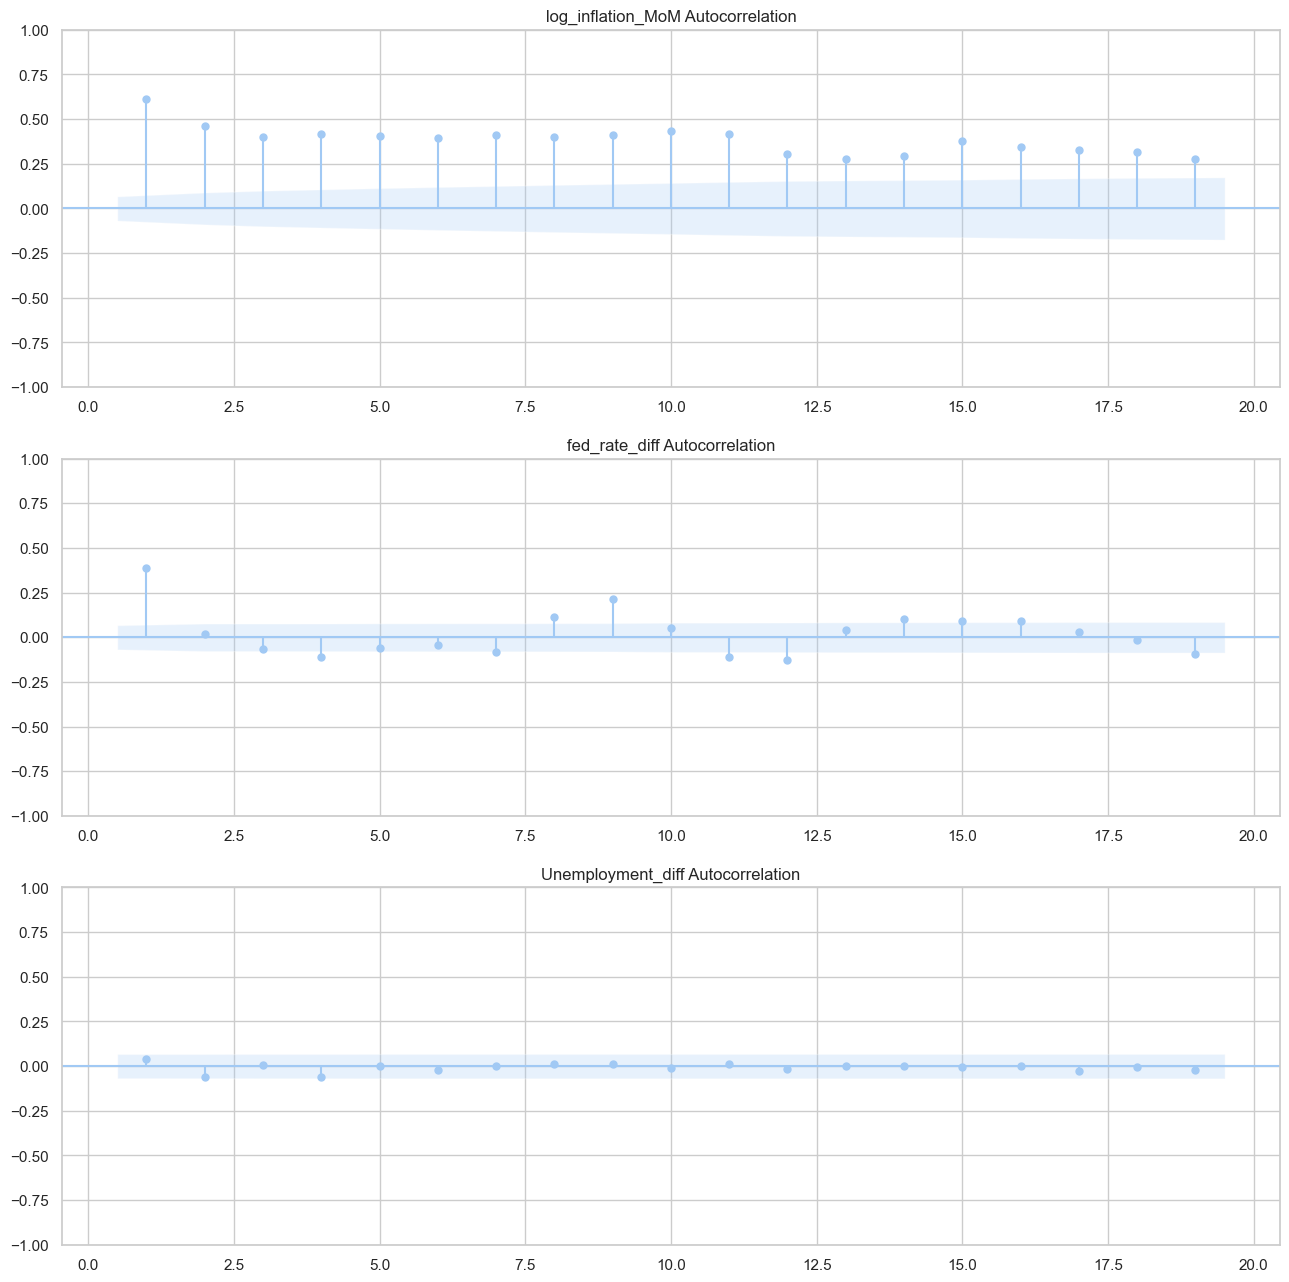

In [87]:
# ACF plots
fig, axs = plt.subplots(3,1, figsize=(14,15))
for i, series in enumerate(series_names.keys()):
    g = plot_acf(data_diff[series], ax=axs[i], lags=np.arange(1, 20))
    axs[i].set_title(f"{series} Autocorrelation")

### ADF tests with statsmodels fixing $\alpha=0.05$
### $H_0: \text{unit root}$ $H_A: \text{stationary}$

In [97]:
series_names.keys()

dict_keys(['log_inflation_MoM', 'fed_rate_diff', 'Unemployment_diff'])

In [101]:
# Check train set
# regression term for inflation is set to constant as it fluctuates around a non-zero mean
from statsmodels.tsa.stattools import adfuller
alpha = 0.05
for var in series_names.keys():
    regression_term = 'c' if var == 'log_inflation_MoM' else 'n'
    p_value = adfuller(data_diff.loc[:cutoff_date, var], regression=regression_term)[1]
    status = "Failed to reject H0. Unit root present." if p_value > alpha else "Reject H0. Data are stationary."
    print(f"ADF test p-value for {var}:", p_value, status)


ADF test p-value for log_inflation_MoM: 0.06212322404868031 Failed to reject H0. Unit root present.
ADF test p-value for fed_rate_diff: 3.210543607831243e-08 Reject H0. Data are stationary.
ADF test p-value for Unemployment_diff: 4.554988266815797e-12 Reject H0. Data are stationary.


In [100]:
# Check full series
from statsmodels.tsa.stattools import adfuller
alpha = 0.05
for var in series_names.keys():
    regression_term = 'c' if var == 'log_inflation_MoM' else 'n'
    p_value = adfuller(data_diff.loc[:, var], regression=regression_term)[1]
    status = "Failed to reject H0. Unit root present." if p_value > alpha else "Reject H0. Data are stationary."
    print(f"ADF test p-value for {var}:", p_value, status)

ADF test p-value for log_inflation_MoM: 0.013746359763393234 Reject H0. Data are stationary.
ADF test p-value for fed_rate_diff: 1.0401329729400197e-09 Reject H0. Data are stationary.
ADF test p-value for Unemployment_diff: 0.0 Reject H0. Data are stationary.


In [102]:
# Since log inflation is not stationary in the train set, we will try a boxcox transform:
transformed = boxcox(data["CPI"].dropna())

lambda_ = transformed[1]
transformed = pd.DataFrame(transformed[0], columns = ["CPI"], index = data["CPI"].dropna().index)\
    .diff().dropna()

p_value = adfuller(transformed.loc[:cutoff_date, :].dropna(), regression="c")[1]
status = "Failed to reject H0. Unit root present." if p_value > alpha else "Reject H0. Data are stationary."
print(p_value, status)

0.004686885859074655 Reject H0. Data are stationary.


In [103]:
# switch the log transformed inflation to the box-cox transform
def box_cox_transform_cpi(data):
    transformed = boxcox(data["CPI"].dropna())
    lambda_ = transformed[1]
    data.loc[~data['CPI'].isna(),'CPI'] = transformed[0]
    return data, lambda_
    
test_data = get_data(fred_data)
box_cox_transform_cpi(test_data)
test_data.loc[:,'CPI'].tail()

2024-09-01    10.409383
2024-10-01    10.416102
2024-11-01    10.424425
2024-12-01    10.435250
2025-01-01    10.449114
Freq: MS, Name: CPI, dtype: float64

Text(0.5, 1.0, 'Box-Cox transformed inflation Autocorrelation')

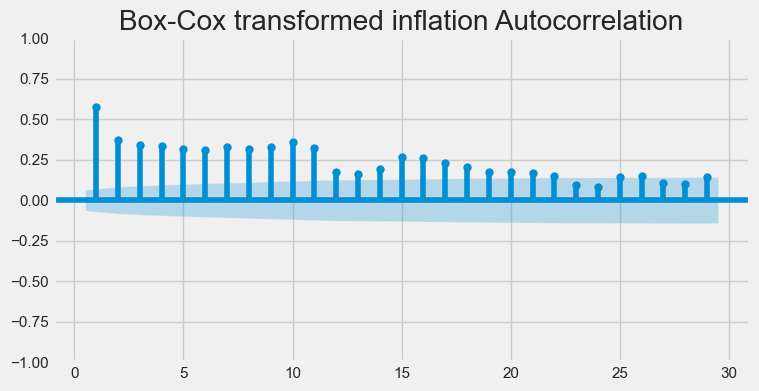

In [107]:
fig, axs = plt.subplots(1,1, figsize=(8,4))

g = plot_acf(test_data.loc[:,'CPI'].diff().dropna(), ax=axs, lags=np.arange(1, 30))
axs.set_title(f"Box-Cox transformed inflation Autocorrelation")

Text(0.5, 1.0, 'Differenced')

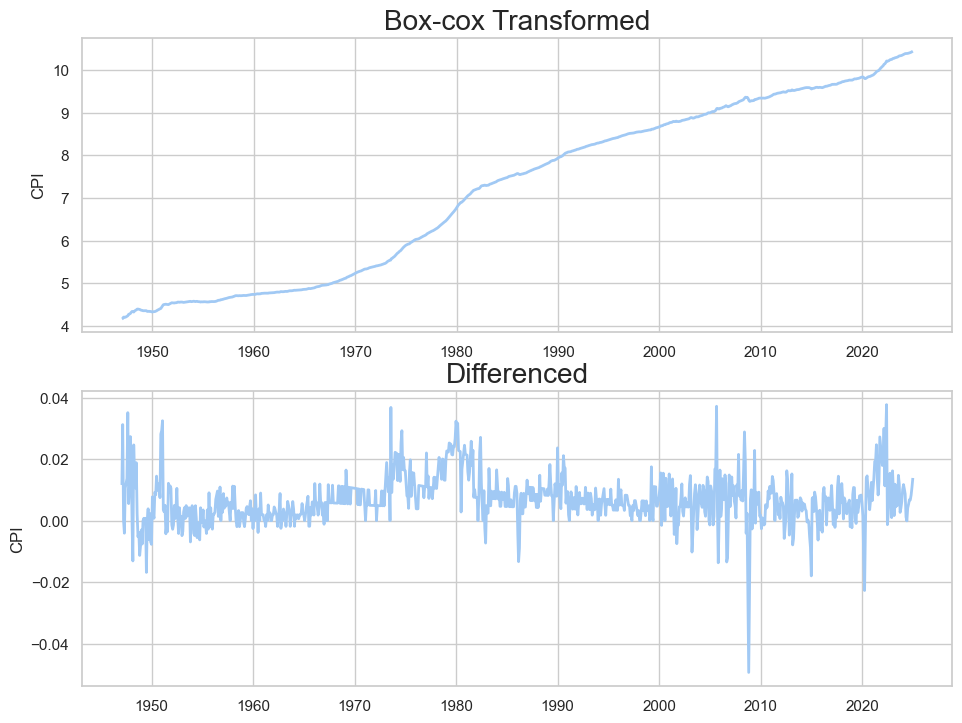

In [109]:
sns.set_theme(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(2,1, figsize=(10,8))
plt.style.use('fivethirtyeight')
ax[0].set_title("Box-cox Transformed")
g = sns.lineplot(
    data=test_data.loc[:,'CPI'], ax=ax[0], linewidth=2
)

g = sns.lineplot(
    data=test_data.loc[:,'CPI'].diff(), ax=ax[1], linewidth=2
)
ax[1].set_title("Differenced")

In [ ]:
# Will difference CPI one more time since there appears to be a part where the mean shifts between around 1970 to about 1985

### Update config

In [110]:
%%writefile configs/time_series_config.yaml
FRED:
    CPIAUCSL:
        name: CPI
        log: false
        diff: true
        n_diffs: 2
        diff_name: log_inflation_MoM
    FEDFUNDS:
        name: fed_rate
        log: true
        diff: true
        n_diffs: 1
    UNRATE:
        name: Unemployment
        log: false
        diff: true
        n_diffs: 1

Overwriting configs/time_series_config.yaml


## Prepare data so it can be passed into PyTorch

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# We will scale the variables so that one series does not dominate
scaler = MinMaxScaler() if scaling_mode == "min-max" else StandardScaler()


class MonetaryPolicyDataSet(torch.utils.data.Dataset):
    def __init__(self, mode:["train", "test", "validation", "full"]='train', train_end_date=None, 
                 validation_end_date=None, seq_length=3, transform = True):
        """ 
        Parameters
        ----------
        mode: str
            'train', 'test', 'validation'
        """
        self.data_mode = mode

        self.seq_length = seq_length

        # Get data configs.
        # Includes settings such as differencing the series or taking logs
        configs = get_data_config(config_path / "time_series_config.yaml")
        self.data_dict = configs["FRED"]
        
        
        data = get_data(self.data_dict)
        data, self.lambda_ = box_cox_transform_cpi(data)
        self.data = difference_data(data, self.data_dict)[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]]

        if self.data_mode != "full":
            self.split_data(train_end_date, validation_end_date)
        
        # Convert to pytorch tensor
        if transform:
            self.data = scaler.transform(self.data)
            if self.data_mode=='train':
                print(self.data)
            self.data = torch.tensor(self.data)
        else:
            self.data = torch.tensor(self.data.values)
        
        
    def __getitem__(self, t):
        return self.data[t: t + self.seq_length], self.data[t + self.seq_length]
    
    
    def __len__(self):
        return len(self.data) - self.seq_length
    

    def split_data(self, train_end_date, validation_end_date):
        if self.data_mode == "train":
            self.data = self.data.loc[:train_end_date]
            scaler.fit(self.data)
            
        elif self.data_mode == "validation":
            # Create  validation set after the train_end_date
            self.data = self.data.loc[pd.to_datetime(train_end_date) + pd.DateOffset(months=1) : validation_end_date]
        
        else:
            # Create test set after the validation_end_date
            assert validation_end_date is not None, "In testing mode, please add validation_end_date"
            self.data = self.data.loc[pd.to_datetime(validation_end_date) + pd.DateOffset(months=1):]

    
    def get_lambda(self):
        return self.lambda_
        

In [113]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(train_cutoff, validation_cutoff, seq_length, transform = True):
    # note: validation_cutoff_date is where the train set ends 
    train_dataset = MonetaryPolicyDataSet(
            mode="train", train_end_date=validation_cutoff,
            seq_length = seq_length, transform=transform
        )
    
    validation_dataset = MonetaryPolicyDataSet(
            mode="validation", train_end_date=validation_cutoff,
            validation_end_date= train_cutoff,
            seq_length = seq_length, transform=transform
        )
    
    test_dataset = MonetaryPolicyDataSet(
            mode='test', train_end_date=train_cutoff, 
            validation_end_date= train_cutoff,
            seq_length = seq_length, transform=transform
        )

    full_data = MonetaryPolicyDataSet(
            mode='full',
            seq_length = seq_length, 
            transform=transform
        )

    lambda_ = train_dataset.get_lambda()
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    full_dataloader = DataLoader(full_data, batch_size=batch_size)
    
    return train_dataloader, validation_dataloader, test_dataloader, full_dataloader, lambda_ 

train_dataloader, validation_dataloader, test_dataloader, full_dataloader, lambda_ = get_data_loaders(
        train_cutoff=cutoff_date, 
        validation_cutoff=validation_cutoff_date,
        seq_length=seq_length, 
        transform=True,
    )

# look at some train data
batch_id, (x, y) = next(enumerate(train_dataloader))
print(x, y)
print(x.size())

[[ 0.89667078  4.13967239  1.02423486]
 [-0.39345755 -1.330913    0.51913274]
 [-0.6540727  -2.30980129 -2.00637788]
 ...
 [-2.96443009 -0.03352409 -0.49107151]
 [-0.30064122  0.0081148   0.51913274]
 [ 2.0546593   0.43313092  0.01403061]]
tensor([[[ 0.8967,  4.1397,  1.0242],
         [-0.3935, -1.3309,  0.5191],
         [-0.6541, -2.3098, -2.0064]],

        [[-0.3935, -1.3309,  0.5191],
         [-0.6541, -2.3098, -2.0064],
         [ 1.9366, -0.2690, -2.0064]],

        [[-0.6541, -2.3098, -2.0064],
         [ 1.9366, -0.2690, -2.0064],
         [-0.9123,  4.2504, -1.5013]],

        [[ 1.9366, -0.2690, -2.0064],
         [-0.9123,  4.2504, -1.5013],
         [ 0.1237,  0.7818, -0.4911]]], dtype=torch.float64) tensor([[ 1.9366, -0.2690, -2.0064],
        [-0.9123,  4.2504, -1.5013],
        [ 0.1237,  0.7818, -0.4911],
        [ 0.6410, -0.7719, -0.9962]], dtype=torch.float64)
torch.Size([4, 3, 3])


In [11]:
# Look at test data
batch_id, (x, y) = next(enumerate(test_dataloader))
print(x)

tensor([[[ 0.7580, -0.5682, -2.5115],
         [-0.4025, -0.5988, -0.9962],
         [-0.0194, -0.6331, -0.4911]],

        [[-0.4025, -0.5988, -0.9962],
         [-0.0194, -0.6331, -0.4911],
         [ 1.0048, -1.3540,  0.0140]],

        [[-0.0194, -0.6331, -0.4911],
         [ 1.0048, -1.3540,  0.0140],
         [-0.2503, -3.3610,  0.5191]],

        [[ 1.0048, -1.3540,  0.0140],
         [-0.2503, -3.3610,  0.5191],
         [-0.7846, -1.0755, -0.4911]]], dtype=torch.float64)


## Baseline Vector Auto Regression

In [114]:
var_train =  pd.DataFrame(train_dataloader.dataset.data, 
                          columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]
) 
var_test = pd.DataFrame(validation_dataloader.dataset.data, 
                        columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]
)

print(var_train.tail())
print(var_test.head())

     log_inflation_MoM  fed_rate_diff  Unemployment_diff
535           0.290930       0.069813          -0.996174
536           2.951238      -0.178500           0.519133
537          -2.964430      -0.033524          -0.491072
538          -0.300641       0.008115           0.519133
539           2.054659       0.433131           0.014031
   log_inflation_MoM  fed_rate_diff  Unemployment_diff
0          -0.891895       0.123763          -0.491072
1           0.869463       0.254812           0.014031
2          -1.178935      -0.071487          -0.491072
3          -0.006993       0.376257           0.014031
4           0.283953      -0.254934          -0.491072


In [115]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(var_train)

In [116]:
# Determine number of lags for the VAR
order = model.select_order(15)
print(order.summary())
print(order.selected_orders)
order_selection = order.selected_orders['aic']
# VAR of order 2 is selected for BIC criterion while order 10 is selected for AIC

fit = model.fit(maxlags=order_selection, ic="bic")
fit.summary()

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.1437     -0.1193      0.8662     -0.1341
1      -0.4241     -0.3266      0.6544     -0.3859
2      -0.5313    -0.3607*      0.5879     -0.4645
3      -0.5671     -0.3234      0.5672     -0.4717
4      -0.6302     -0.3135      0.5325    -0.5062*
5      -0.6561     -0.2663      0.5189     -0.5034
6      -0.6632     -0.2003      0.5152     -0.4819
7      -0.6688     -0.1328      0.5124     -0.4589
8     -0.6917*    -0.08262     0.5008*     -0.4532
9      -0.6679     0.01423      0.5129     -0.4008
10     -0.6802     0.07508      0.5067     -0.3844
11     -0.6821      0.1462      0.5058     -0.3578
12     -0.6785      0.2229      0.5077     -0.3255
13     -0.6723      0.3022      0.5110     -0.2907
14     -0.6798      0.3677      0.5073     -0.2696
15     -0.6698      0.4509      0.5125     -0.2310
-------------------------------

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Feb, 2025
Time:                     09:43:37
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.315972
Nobs:                     538.000    HQIC:                 -0.417873
Log likelihood:          -2139.15    FPE:                   0.616722
AIC:                    -0.483342    Det(Omega_mle):        0.593262
--------------------------------------------------------------------
Results for equation log_inflation_MoM
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.004020         0.038005           -0.106           0.916
L1.log_inflation_MoM        -0.536500         0.042582          -12.599           0.000
L1.fed_rate_diff    

In [117]:
# Generate forecasts
forecasts = fit.forecast(var_train.values[-order_selection:], var_test.shape[0])
assert len(forecasts) == var_test.shape[0]
forecasts[:5]

array([[-1.02959627, -0.01460604,  0.17675606],
       [ 0.11655789, -0.14501993, -0.05492986],
       [ 0.14248895,  0.02430444,  0.04608084],
       [-0.11303336, -0.0128946 ,  0.0038795 ],
       [ 0.02384783, -0.02235085,  0.00348162]])

In [118]:
print(len(validation_dataloader.dataset.data))
print(var_test.shape[0])

136
136


In [119]:
# Calculate error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
forecasts_t = torch.tensor(forecasts)
mse = nn.MSELoss()
print("MSE",mse(forecasts_t, validation_dataloader.dataset.data))
print("MAE",mean_absolute_error(forecasts_t, validation_dataloader.dataset.data))

MSE tensor(2.1491, dtype=torch.float64)
MAE 0.9025412711116281


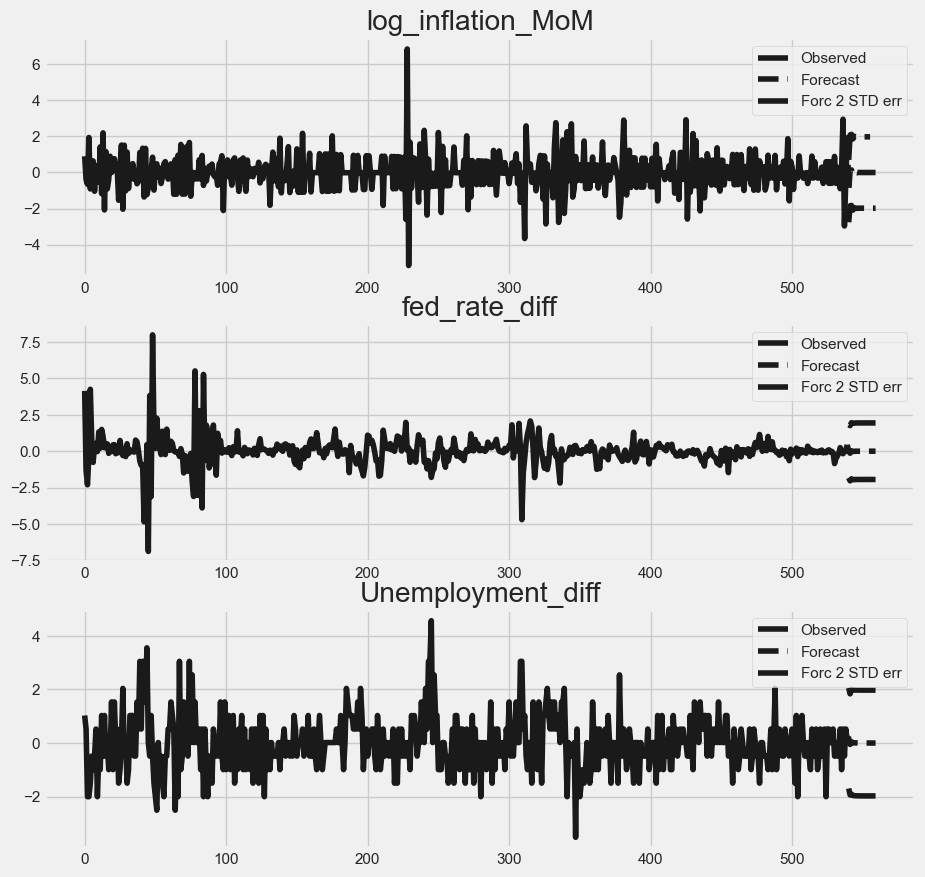

In [120]:
h = fit.plot_forecast(20)

## Build and test RNN

Note that neural networks can handle non-stationary data but we keep them stationary for easy direct comparison in performance metrics. 

In [279]:
import torch.functional as F
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        self.recurrent_layer = torch.nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first = True,
            bidirectional = False
        )
        
        self.fc1 = torch.nn.Linear(hidden_size, 3, bias=True)

        self.latest_X = None
        
    def forward(self, x):
        x, hidden = self.recurrent_layer(x)
        x = self.fc1(x[:,-1, :])
        
        return x  

    def set_latest_X(self, X):
        self.latest_X = X

## Test forward

In [645]:
scaled_data = scaler.transform(data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]])
scaled_data_df = pd.DataFrame(scaled_data, columns = ["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"], index=data_diff.index)
scaled_data_df = scaled_data_df[scaled_data_df != "2020-04-01"]
scaled_data_df.head()

log_inflation_MoM  fed_rate_diff  Unemployment_diff
1954-08-01          13.016129       4.139672           1.024235
1954-09-01          -5.586520      -1.330913           0.519133
1954-10-01          -9.307050      -2.309801          -2.006378
1954-11-01          27.898248      -0.268993          -2.006378
1954-12-01         -13.027580       4.250385          -1.501276

In [648]:
# Test forward pass
model = RNNModel(3, 20).to(device)
torch.manual_seed(1)
test_input = x.float().to(device)
print("Input:")
print(test_input.float())
print(test_input.shape)
with torch.no_grad():
    print("Output: ")
    out = model(test_input)
    print(out)
    print("true values:", y.float())

Input:
tensor([[[-0.2152,  0.5012,  0.5191],
         [ 0.0737, -0.0335,  0.0140],
         [ 0.9547, -0.0335, -0.4911]]], device='cuda:0')
torch.Size([1, 3, 3])
Output: 
tensor([[-0.3913, -0.2403,  0.1233]], device='cuda:0')
true values: tensor([[-0.4923, -0.0335,  2.0344]], device='cuda:0')


In [649]:
mse = nn.MSELoss()
mse(model(test_input), y.to(device))

tensor(1.2352, device='cuda:0', grad_fn=<MseLossBackward0>)

## Train RNN

In [37]:
from torch import optim
import torch.nn as nn

class RNN:
    def __init__(self, rnn, model_name, n_epoch:int, 
                 train_loader, validation_loader=None, 
                 learning_rate:float=0.0001, gradient_clipping=None,
                 device = None, train_data_end_date = None,
                ):
        """ Trainer for the rnn.
        
        Parameters
        ----------
        rnn : torch.nn.Module
            PyTorch model to be trained
        model_name : str
            name of the model that will be saved models folder
        n_epoch : int
            number of epochs for training
        train_loader : DataLoader
        validation_loader : DataLoader
        learning_rate : float
        gradient_clipping: bool
            Clip large gradients
        device: str
            Device used for training
        train_data_end_date: str
            The date where the train data ends
        """
        self.n_epoch, self.lr, self.graident_clip = n_epoch, learning_rate, gradient_clipping

        self.train_loader, self.validation_loader = train_loader, validation_loader
        
        self.net = rnn
        self.model_name = model_name
        
        self.optimizer = optim.Adam(
                lr=self.lr, 
                params=self.net.parameters()
            ) 
        
        # Mean squared error loss
        self.loss = nn.MSELoss()

        self.best_validation_loss = 1000000 # arbritrary large number just to initialize
        self.best_model = None
        self.device = device
        
        # Keep track of date when the train set ends
        self.train_data_end_date = train_data_end_date

        
    def train(self):
        with mlflow.start_run() as run:
            self.run = run
            self.log_params()
            
            self.train_error = []
            self.val_error = []
            for epoch in range(1, self.n_epoch + 1):
                self.train_loop(epoch)
                if self.validation_loader:
                    self.validation(epoch)
            self.log_loss()
            
            if self.validation_loader:
                print("Saving best model with lowest validation mse loss = {}".format(self.best_validation_loss)) 
                mlflow.log_metric("Best-validation-loss", self.best_validation_loss)
            else:
                torch.save(self.net, model_folder / f"{self.model_name}.pt")
            #self.log_model()
        
        
    def train_loop(self, epoch):
        self.net.train()
        losses = []
        for idx, (x, y) in enumerate(self.train_loader):
            
            x = x.to(self.device).float()
            y = y.to(self.device).float()

            # Calculate losses and optimize 
            self.optimizer.zero_grad()
            output = self.net(x)
            loss = self.loss(output, y)
            losses.append(loss.item())
            loss.backward()

            if self.graident_clip:
                nn.utils.clip_grad_norm_(self.net.parameters(), self.graident_clip)

            self.optimizer.step()

            # Print progress
            if idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(x), len(self.train_loader.dataset),
                100. * idx / len(self.train_loader), loss.item()))
                
        avg_loss = np.mean(losses)
        self.train_error.append(avg_loss)
        print("Epoch {} average train loss: {:.6f}".format(epoch, avg_loss))
        self.net.set_latest_X(x)

    
    def validation(self, epoch):
        """
        Test model on validation data
        """
        losses = []
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(self.device).float()
            y = y.to(self.device).float()
            
            self.net.eval()
            with torch.no_grad():
                validation_output = self.net(x)#.reshape(-1,3)
                loss_val = self.loss(validation_output, y)
                losses.append(loss_val.item())
                
        avg_loss = np.mean(losses)

        # Track the best model and validation loss
        if avg_loss < self.best_validation_loss:
            self.best_validation_loss = avg_loss
            torch.save(self.net, model_folder / f"{self.model_name}.pt")
            
        self.val_error.append(avg_loss)
        print("Epoch {} average validation loss: {:.6f}".format(epoch, avg_loss))
    
    
    def log_params(self):
        """
        Logging model parameters with MLflow
        """
        mlflow.log_params(
            {
                "batch size": batch_size,
                "epochs": self.n_epoch,
                "sequence length": seq_length,
                "learning_rate": self.lr,
                "hidden size": self.net.hidden_size,
                "optimizer": self.optimizer,
                "gradient clipping": self.graident_clip,
                "Train data end": self.train_data_end_date,
                "Train data size": len(train_dataloader.dataset),
                "Validation data size": len(test_dataloader.dataset),
                "scaling": scaling_mode,
            }
        )
 

    def log_model_weights(self, epoch):
        """
        Logs the models parameters ever couple of epochs.
        """
        if epoch % 10 == 0:
            with torch.no_grad():
                for i, param in enumerate(self.net.parameters()):
                    p = param.cpu().numpy()
                    df = pd.DataFrame(p)
                    df.to_csv(f"./params/params_{i}.csv")
                mlflow.log_artifacts("./params", f"./params/{epoch}")


    def log_model(self):
        """
        Uses MLflow to log the best model in pytorch flavour
        """
               
        best_model = torch.load(model_folder / f"{self.model_name}.pt")
        best_model.eval()
        mlflow.pytorch.log_model(best_model, "best_model")
        mlflow.sklearn.log_model(scaler, "scaler")


    def log_loss(self):
        """
        Logging train and validation performance with MLflow
        """
        log_every = 10
        for epoch, val in enumerate(self.train_error):
            if epoch % log_every == 0:
                mlflow.log_metric(f"train mean loss", val, step=epoch)
        if self.validation_loader:
            for epoch, val in enumerate(self.val_error):
                if epoch % log_every == 0:
                    mlflow.log_metric(f"val-loss", val, step=epoch)

    
    def predict(self, x:torch.tensor):
        """
        Generate a prediction with the model. 
        Each output contains predictions for inflation, unemployment, and Fed rate.
        input:
            x: tensor size [n_samples, 3]
        returns:
            torch.tensor: size [n_samples, 3]
        """
        with torch.no_grad():
            return self.net(x.to(self.device).float())
            
            
    def load_model(self, path):
        """
        Load a pytorch model
        input:
            path: path to torch model
        """
        self.net = torch.load(path, weights_only=False)

    def set_model(self, model):
        self.net = model

In [286]:
# Set the training experiment
mlflow.set_experiment('MonetaryPolicyRNN')
hidden_size = 12

# Initialize model
model = RNNModel(3, hidden_size).to(device)
rnn = RNN(model, "RNN", 120, train_dataloader, validation_dataloader, 
          learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)
# Train
rnn.train()

Train Epoch: 1 [0/537 (0%)]	Loss: 3.035289
Train Epoch: 1 [400/537 (74%)]	Loss: 0.867114
Epoch 1 average train loss: 1.095554
Epoch 1 average validation loss: 2.302602
Train Epoch: 2 [0/537 (0%)]	Loss: 2.994217
Train Epoch: 2 [400/537 (74%)]	Loss: 0.858079
Epoch 2 average train loss: 1.077683
Epoch 2 average validation loss: 2.278755
Train Epoch: 3 [0/537 (0%)]	Loss: 2.962052
Train Epoch: 3 [400/537 (74%)]	Loss: 0.850501
Epoch 3 average train loss: 1.061132
Epoch 3 average validation loss: 2.257217
Train Epoch: 4 [0/537 (0%)]	Loss: 2.932578
Train Epoch: 4 [400/537 (74%)]	Loss: 0.844115
Epoch 4 average train loss: 1.046341
Epoch 4 average validation loss: 2.237939
Train Epoch: 5 [0/537 (0%)]	Loss: 2.905618
Train Epoch: 5 [400/537 (74%)]	Loss: 0.838680
Epoch 5 average train loss: 1.033164
Epoch 5 average validation loss: 2.220691
Train Epoch: 6 [0/537 (0%)]	Loss: 2.880769
Train Epoch: 6 [400/537 (74%)]	Loss: 0.833998
Epoch 6 average train loss: 1.021391
Epoch 6 average validation loss: 2

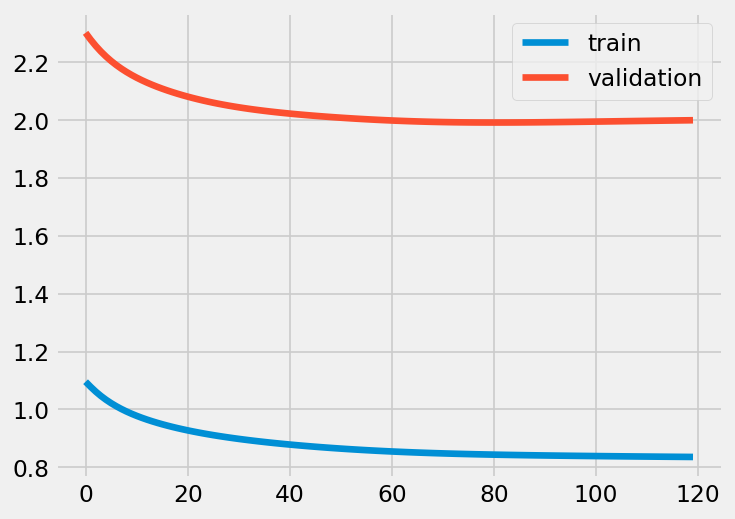

In [287]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(len(rnn.train_error)), rnn.train_error, label='train')
ax.plot(np.arange(len(rnn.val_error)), rnn.val_error, label='validation')
plt.legend()

## Look at some of the fitted values

In [288]:
rnn.load_model("./models/RNN.pt")

In [41]:
def get_predictions(model, loader, return_residuals = False):
    """ Produces model predictions from data in loader. Can
    optionally return model residuals as well.
    Parameters
    ----------
    model: torch.nn.Module
        pytorch model to use for producing predictions
    loader: torch.utils.data.DataLoader
        data loader that contains the data for 
    """
    predictions = []
    residuals = []
    for idx, (x, y) in enumerate(loader):
        pred = model.predict(x)
        predictions.append(pred)
        
        res = pred-y.to(device)
        residuals.append(res)
        
    predictions_concat = torch.concat(predictions, dim=0).cpu().numpy()
    residuals_concat = torch.concat(residuals, dim=0).cpu().numpy()
    if return_residuals:
        return predictions_concat, residuals_concat
    else:
        return predictions_concat

In [42]:

def plot_predictions(model, range_:list, loader, transform = False):
    predictions = get_predictions(model, loader)
    
    # If we are testing we need to start the index at the cutoff for when we concatinate predictions 
    # with the actual values
    
    predictions_df = pd.DataFrame(
        predictions, 
        columns = ["log_inflation_MoM_pred", "fed_rate_diff_pred", "Unemployment_diff_pred"], 
    )

    fig, axs = plt.subplots(3, dpi=120, figsize=(12, 10))
    all_data = pd.concat([pd.DataFrame(loader.dataset.data[seq_length:], columns=["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]), predictions_df], 
                         ignore_index=False, axis=1)
    

    if transform:
        all_data[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]] = scaler.inverse_transform(
            all_data[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]]
        )
        all_data[["log_inflation_MoM_pred", "fed_rate_diff_pred", "Unemployment_diff_pred"]] = scaler.inverse_transform(
            all_data[["log_inflation_MoM_pred", "fed_rate_diff_pred", "Unemployment_diff_pred"]]
        )
        (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]).iloc[range_[0]:range_[1]].plot(ax=axs[0], linewidth=2)
        (all_data[["fed_rate_diff_pred", "fed_rate_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[1], linewidth=2)
        (all_data[["Unemployment_diff_pred", "Unemployment_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[2], linewidth=2)
    else:
        (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]).iloc[range_[0]:range_[1]].plot(ax=axs[0], linewidth=2)
        (all_data[["fed_rate_diff_pred", "fed_rate_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[1], linewidth=2)
        (all_data[["Unemployment_diff_pred", "Unemployment_diff"]]).iloc[range_[0]:range_[1]].plot(ax=axs[2], linewidth=2)

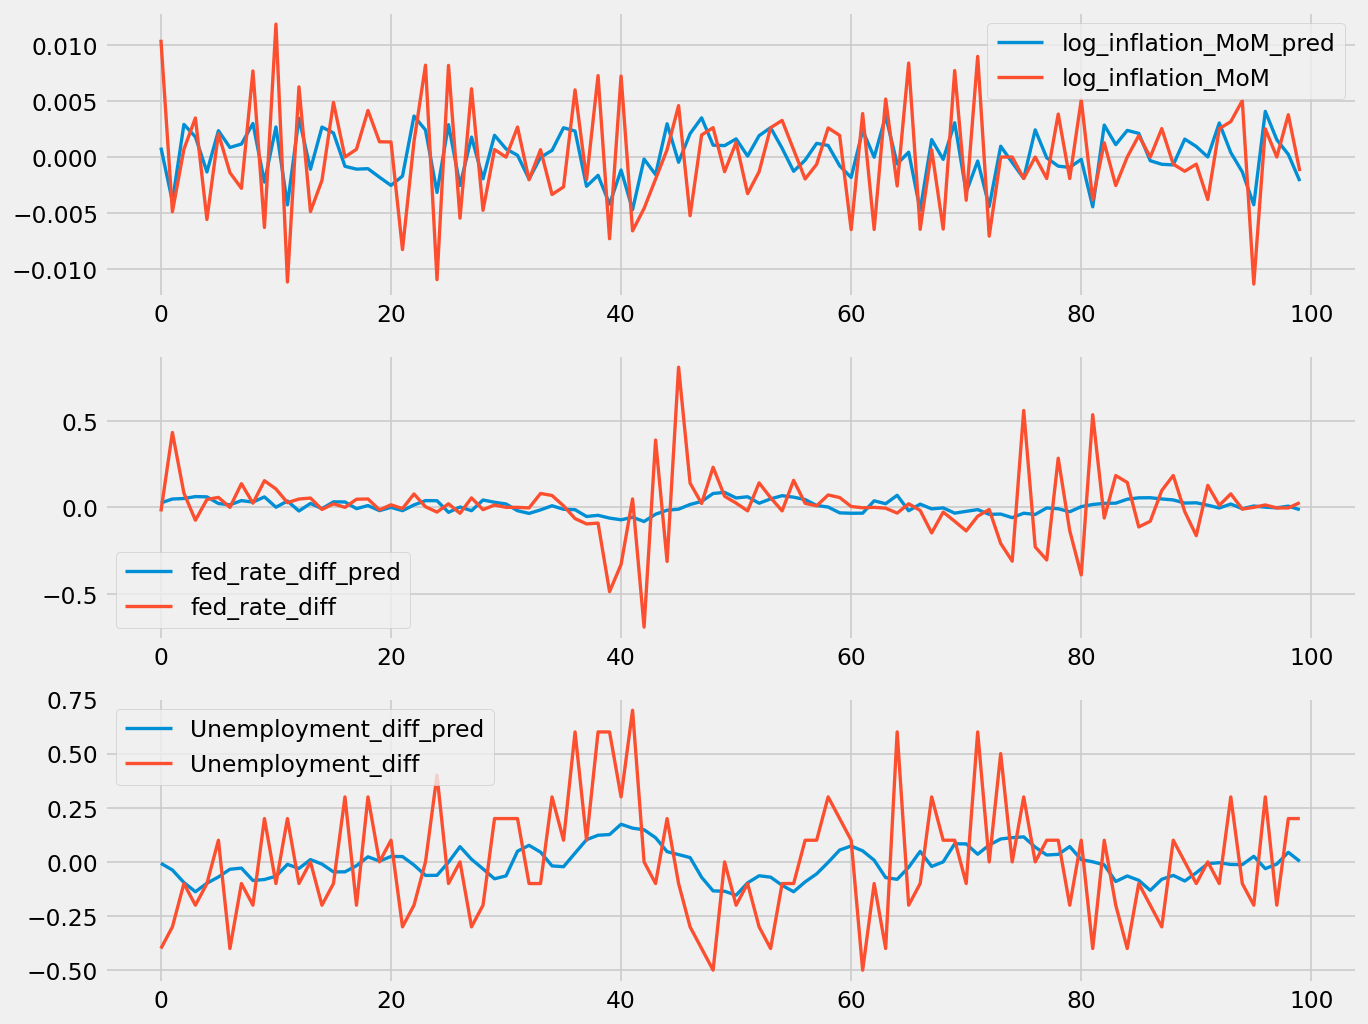

In [301]:
plot_predictions(rnn, [0, 100], train_dataloader, transform=True)

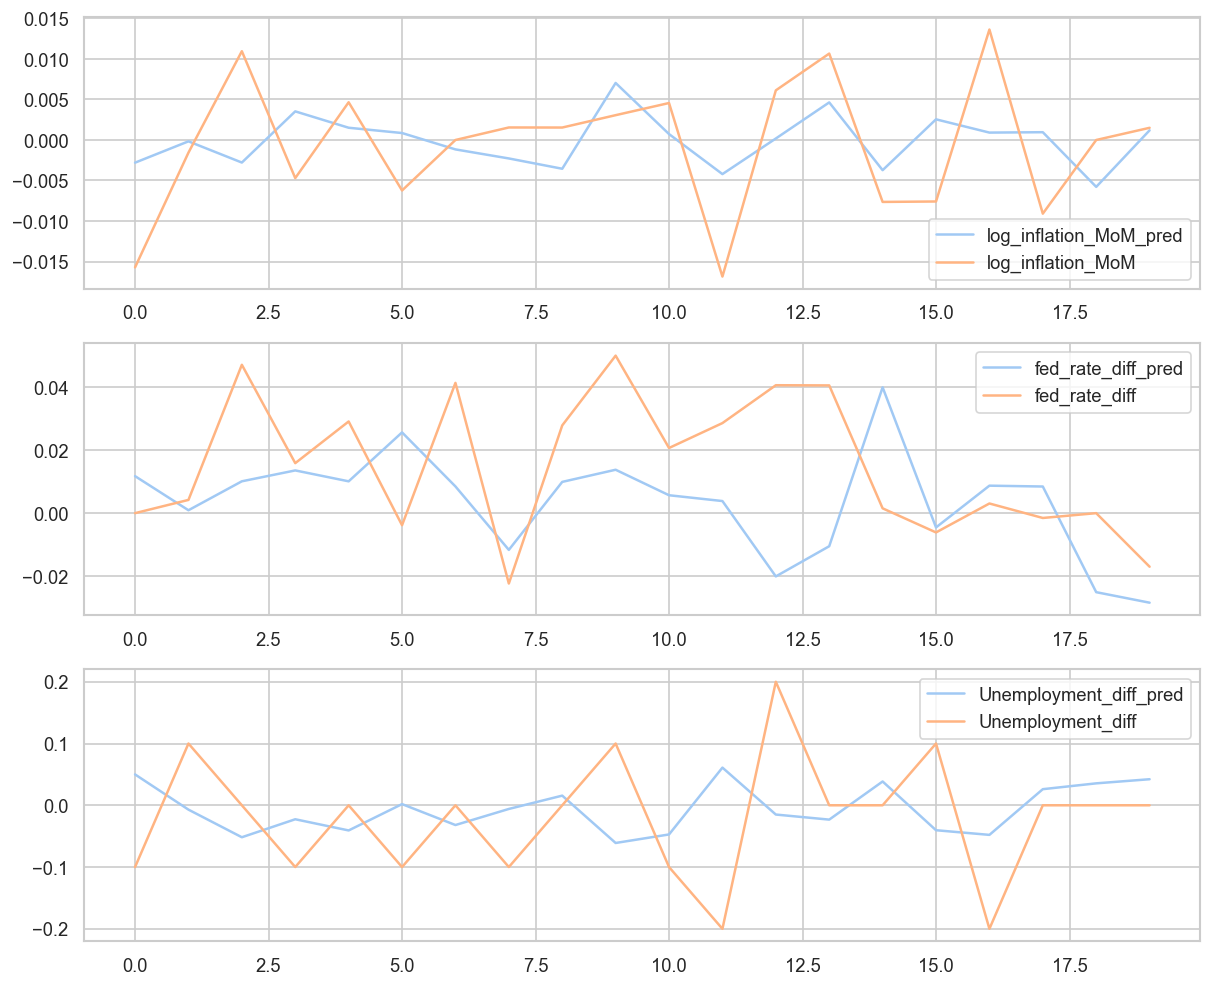

In [72]:
plot_predictions(rnn, [0, 20], validation_dataloader, transform=True)

## Check that residuals are white noise

Text(0.5, 1.0, 'Unemployment_DIFF_pred Residuals')

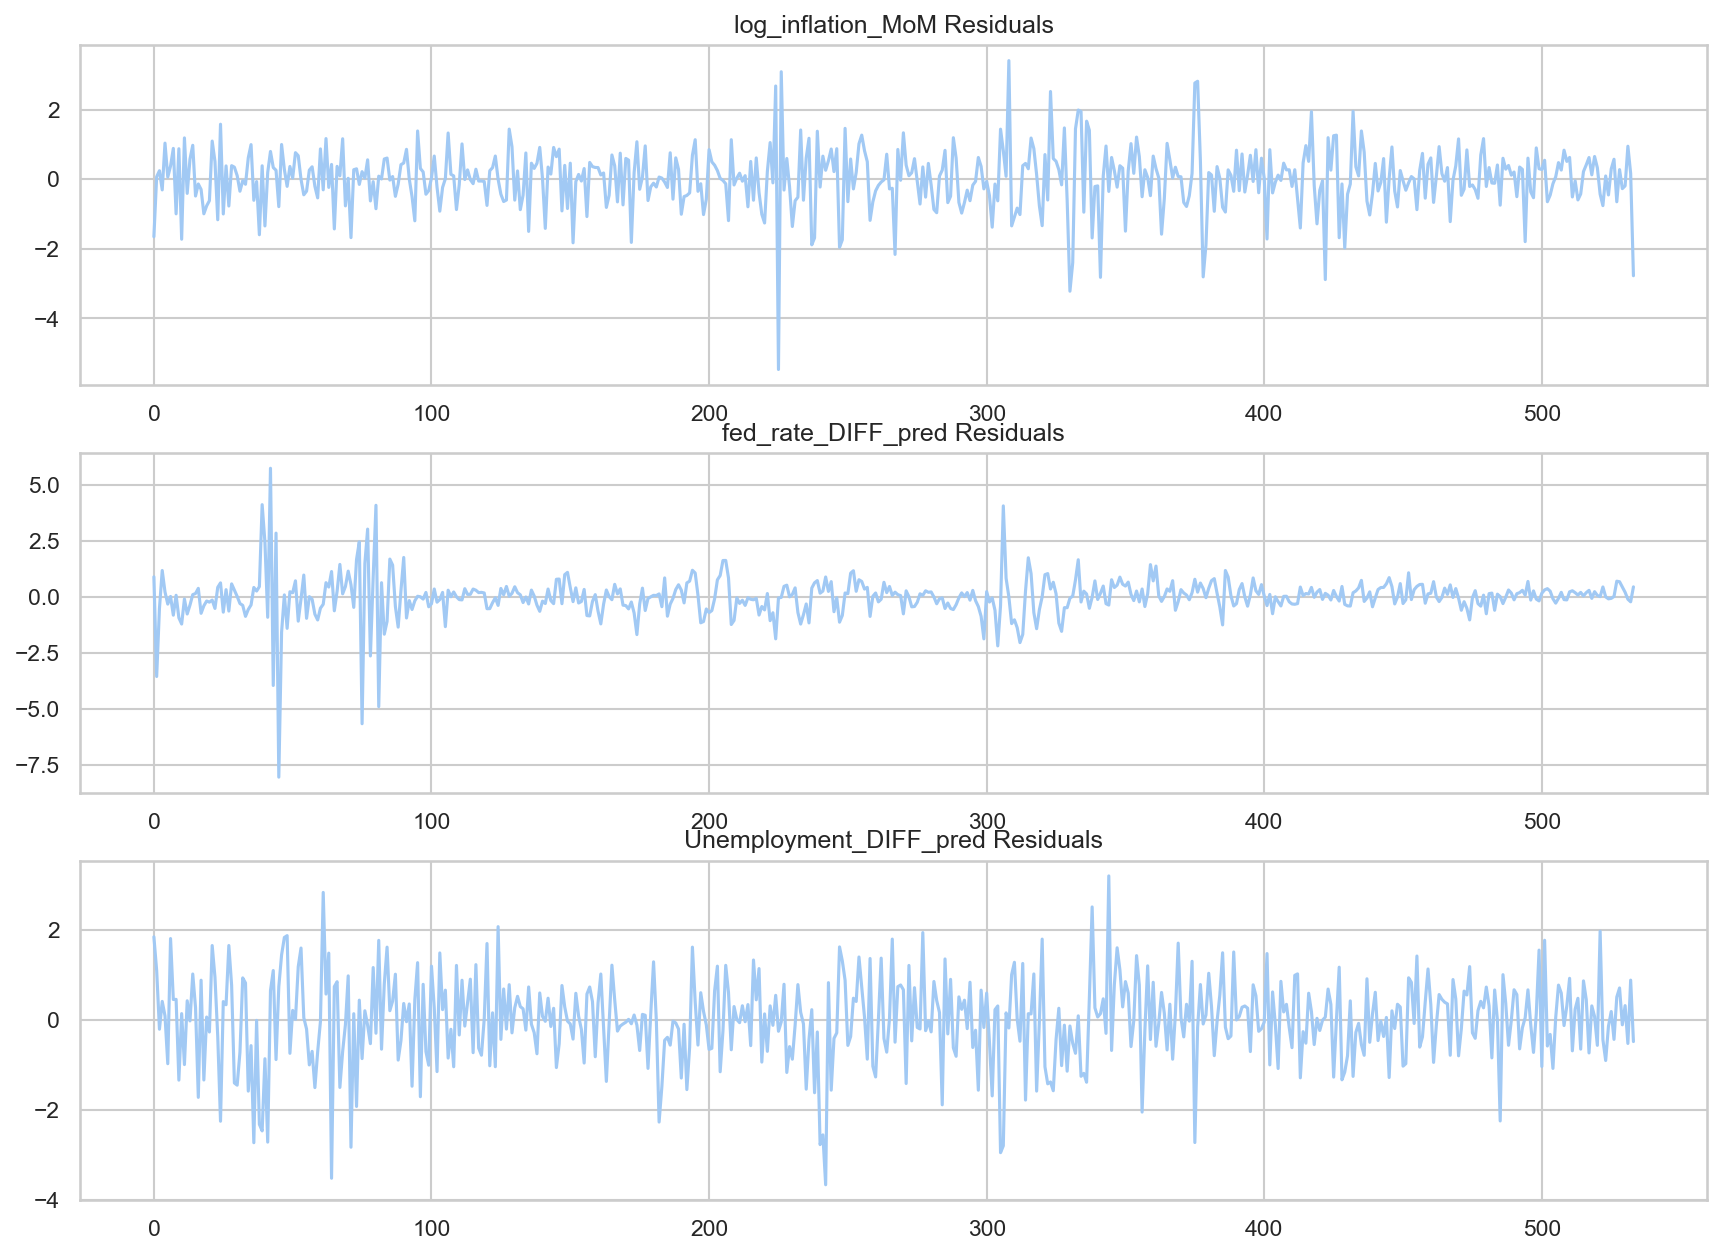

In [73]:
pred, res = get_predictions(rnn, train_dataloader,return_residuals=True)
residuals_df = pd.DataFrame(
        res, 
        columns = ["log_inflation_MoM_pred_res", "fed_rate_DIFF_pred_res", "Unemployment_DIFF_pred_res"]
    )

fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))

residuals_df["log_inflation_MoM_pred_res"].plot(ax=axs[0])
residuals_df["fed_rate_DIFF_pred_res"].plot(ax=axs[1])
residuals_df["Unemployment_DIFF_pred_res"].plot(ax=axs[2])
axs[0].set_title("log_inflation_MoM Residuals")
axs[1].set_title("fed_rate_DIFF_pred Residuals")
axs[2].set_title("Unemployment_DIFF_pred Residuals")

----

# LSTM With Pytorch

----

Let $L = seqlength$, $N=numTimeSeries$

$\mathbf{X}_t \sim B \times L \times N$

Where $B$ is the batch size

$\mathbf{I}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xi} + \mathbf{H}_{t-1}\mathbf{W}_{hi} + \mathbf{b}_{i}) \\ $

$\mathbf{F}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xf} + \mathbf{H}_{t-1}\mathbf{W}_{hf} + \mathbf{b}_{f})$

$\mathbf{O}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xo} + \mathbf{H}_{t-1}\mathbf{W}_{ho} + \mathbf{b}_{o}) \\ $

$\mathbf{O}_t, \mathbf{I}_t, \mathbf{F}_t \in \mathbb{R}^{B \times L \times h}$, $\mathbf{W}_{x.} \in \mathbb{R}^{N \times h}$, $\mathbf{W}_{h. } \in \mathbb{R}^{ h \times h}$, $\mathbf{b}_{.} \in \mathbb{R}^{1 \times h}$

$\mathbf{\tilde{C}}_t = \tanh{(\mathbf{X}_t\mathbf{W}_{xc} + \mathbf{H}_{t-1}\mathbf{W}_{hc} + \mathbf{b}_{c})}$

$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \mathbf{\tilde{C}}_t$

Update hidden state:

$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t)$

Finally:

$\hat{\mathbf{X}}_{t+1} = \mathbf{H}_t\mathbf{W}_{x} + \mathbf{b}_{x} \in \mathbb{R}^{B \times L \times N}$, &nbsp;&nbsp; $\mathbf{H}_t \in \mathbb{R}^{L \times h}$, &nbsp;&nbsp; $\mathbf{W}_{x} \in \mathbb{R}^{h \times N}$, &nbsp;&nbsp; $\mathbf{b}_x \in \mathbb{R}^{1 \times N}$

Remember that the model only keeps the last output, so really
$\hat{\mathbf{X}}_{t+1} \in \mathbb{R}^{B \times 1 \times N}$

Pytorches implementation is a little different due to the addition of biases for input to hidden connections in the input, output, and forget gates


## Input gate, output gate, and forget gate
$\mathbf{I}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xi} + \mathbf{H}_{t-1}\mathbf{W}_{hi} + \mathbf{b}_{i}) \\ $

$\mathbf{O}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xo} + \mathbf{H}_{t-1}\mathbf{W}_{ho} + \mathbf{b}_{o}) \\ $

$\mathbf{F}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xf} + \mathbf{H}_{t-1}\mathbf{W}_{hf} + \mathbf{b}_{f})$

In [30]:
class Gate(nn.Module):
    def __init__(self, input_size, hidden_size, activation = "sigmoid"):
        super(Gate, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Params for input gate
        self.W_xi = nn.Parameter(
            torch.randn(input_size, hidden_size),
        )
        
        self.W_hi = nn.Parameter(
            torch.randn(hidden_size, hidden_size),
        )
         
        self.b_i = nn.Parameter(
            torch.zeros(hidden_size),     
        )
        
        
        self.activation = nn.Tanh() if activation == "tanh" else nn.Sigmoid()

        self.initialize_params()


    def initialize_params(self):
        a = np.sqrt(1/self.hidden_size)
        for param in self.parameters():
            param.data.uniform_(-a, a)
        
    
    def forward(self, X, old_state = None):
        if old_state is None:
            # Initiallize hidden state
            old_state = torch.zeros((X.shape[0], self.hidden_size),
                          device=X.device)   

        return self.activation(torch.matmul(X, self.W_xi) + 
                              torch.matmul(old_state, self.W_hi) + self.b_i) 

In [31]:
# Test the input gate forward pass
I = Gate(3, 5).to(device)
with torch.no_grad():
    print(x[0].shape)
    print(I(x[0].to(device).float()))

torch.Size([3, 3])
tensor([[0.5488, 0.5780, 0.4668, 0.5712, 0.5390],
        [0.5416, 0.5185, 0.4183, 0.6323, 0.5379],
        [0.5114, 0.5005, 0.4882, 0.6002, 0.5176]], device='cuda:0')


## Build the memory cell:
Input node:

$\mathbf{\tilde{C}}_t = \tanh{(\mathbf{X}_t\mathbf{W}_{xc} + \mathbf{H}_{t-1}\mathbf{W}_{hc} + \mathbf{b}_{c})}$

$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \mathbf{\tilde{C}}_t$

Update hidden state:

$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t)$


In [32]:
class MemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MemoryCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.I = Gate(self.input_size, self.hidden_size)
        self.F = Gate(self.input_size, self.hidden_size)
        self.O = Gate(self.input_size, self.hidden_size)
        
        self.input_node = Gate(self.input_size, self.hidden_size, activation='tanh')
        
        self.tanh = nn.Tanh()

    
    def forward(self, X, state = None, internal_state = None):
        if state is None:
            state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)    
        if internal_state is None:
            internal_state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)  
            
        outputs = []
        for x in X:
            I = self.I(x, state)
            F = self.F(x, state)
            O = self.O(x, state)
            input_ = self.input_node(x, state)
            internal_state = F * internal_state + I * input_
            state = O * torch.tanh(internal_state)
            outputs.append(state)
            
        try:
            h = torch.stack(outputs, 0)
        except Exception as e:
            print(e)
            print("shape:", X.shape)
            print("outputs:", outputs)
        else:
            return h, (state, internal_state)

In [33]:
# Test forward
torch.manual_seed(1)
memory = MemoryCell(3, 5).to(device)
with torch.no_grad():
    o, _ = memory(x.to(device).float())
    print(o)

tensor([[[-0.0553,  0.0259, -0.0777,  0.0811,  0.0563],
         [-0.0690,  0.0064, -0.0335,  0.1154,  0.0312],
         [-0.0603,  0.0135, -0.0935,  0.1295,  0.0182]],

        [[-0.1041,  0.0247, -0.0697,  0.1543,  0.0558],
         [-0.1068,  0.0257, -0.1033,  0.1991,  0.0273],
         [-0.0985,  0.0053, -0.1294,  0.1989,  0.0836]],

        [[-0.1268,  0.0383, -0.1186,  0.2179,  0.0378],
         [-0.1248,  0.0168, -0.1305,  0.2388,  0.0846],
         [-0.1483,  0.0077, -0.0644,  0.2106,  0.0858]]], device='cuda:0')


In [34]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.memory = MemoryCell(input_size, hidden_size)
        
        self.fc1 = nn.Linear(hidden_size, 3)

        self.latest_X = None
    
    def forward(self, X):
        x, (h, c) = self.memory(X)
        # x is size (bbatch_size x Seq_len x hidden_size)
        return self.fc1(x[:, -1, :])

    def set_latest_X(self, X):
        self.latest_X = X

In [35]:
# Test forward
#torch.manual_seed(1)
lstm = LSTM(3, 16).to(device)
with torch.no_grad():
    print(x)
    o = lstm(x.to(device).float())
    print("out:\n",o)

tensor([[[ 0.2220, -0.0335,  0.0140],
         [ 0.2649, -0.4117, -0.4911],
         [-0.0203, -0.6294,  0.0140]],

        [[ 0.2649, -0.4117, -0.4911],
         [-0.0203, -0.6294,  0.0140],
         [ 0.2926, -0.4304,  0.5191]],

        [[-0.0203, -0.6294,  0.0140],
         [ 0.2926, -0.4304,  0.5191],
         [ 0.4596, -0.3805, -0.4911]]], device='cuda:0')
out:
 tensor([[-0.1416,  0.2425, -0.1866],
        [-0.1041,  0.2665, -0.2100],
        [-0.1399,  0.2799, -0.2178]], device='cuda:0')


### Train the network

In [38]:
hidden_size = 12
seq_length = 3
train_dataloader, validation, test_dataloader, full_data_loader, lambda_ = get_data_loaders(cutoff_date, validation_cutoff_date, seq_length, transform=True)

lstm = LSTM(3, hidden_size).to(device)
lstm_model = RNN(lstm, "LSTM", 120, train_dataloader, validation_dataloader, 
                 learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)

mlflow.set_experiment('LSTM_training')
# Train LSTM
lstm_model.train()

[[ 0.89667078  4.13967239  1.02423486]
 [-0.39345755 -1.330913    0.51913274]
 [-0.6540727  -2.30980129 -2.00637788]
 ...
 [-2.96443009 -0.03352409 -0.49107151]
 [-0.30064122  0.0081148   0.51913274]
 [ 2.0546593   0.43313092  0.01403061]]
Train Epoch: 1 [0/537 (0%)]	Loss: 2.772877
Train Epoch: 1 [400/537 (74%)]	Loss: 0.904870
Epoch 1 average train loss: 1.015053
Epoch 1 average validation loss: 2.166409
Train Epoch: 2 [0/537 (0%)]	Loss: 2.755724
Train Epoch: 2 [400/537 (74%)]	Loss: 0.899900
Epoch 2 average train loss: 1.010530
Epoch 2 average validation loss: 2.161942
Train Epoch: 3 [0/537 (0%)]	Loss: 2.738081
Train Epoch: 3 [400/537 (74%)]	Loss: 0.895089
Epoch 3 average train loss: 1.006165
Epoch 3 average validation loss: 2.157630
Train Epoch: 4 [0/537 (0%)]	Loss: 2.720651
Train Epoch: 4 [400/537 (74%)]	Loss: 0.890484
Epoch 4 average train loss: 1.002023
Epoch 4 average validation loss: 2.153459
Train Epoch: 5 [0/537 (0%)]	Loss: 2.703706
Train Epoch: 5 [400/537 (74%)]	Loss: 0.886080

In [81]:
experiment_id = mlflow.get_experiment_by_name("LSTM_training").experiment_id
print(experiment_id)

2


In [39]:
# Load saved best model
lstm_model.load_model("./models/LSTM.pt")

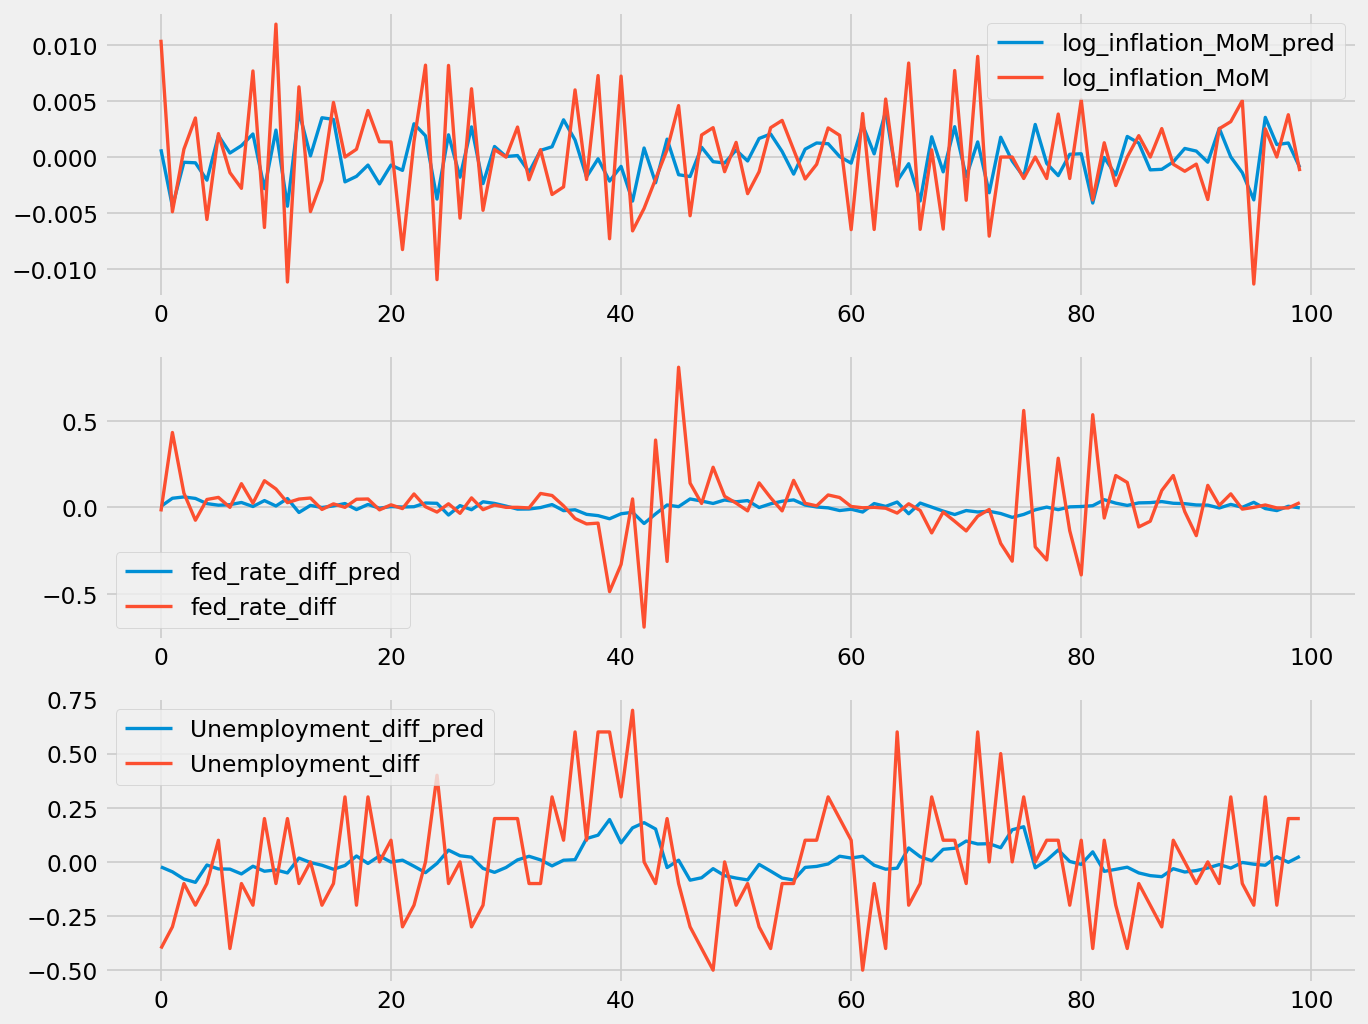

In [43]:
plot_predictions(lstm_model, [0, 100], train_dataloader, transform=True)

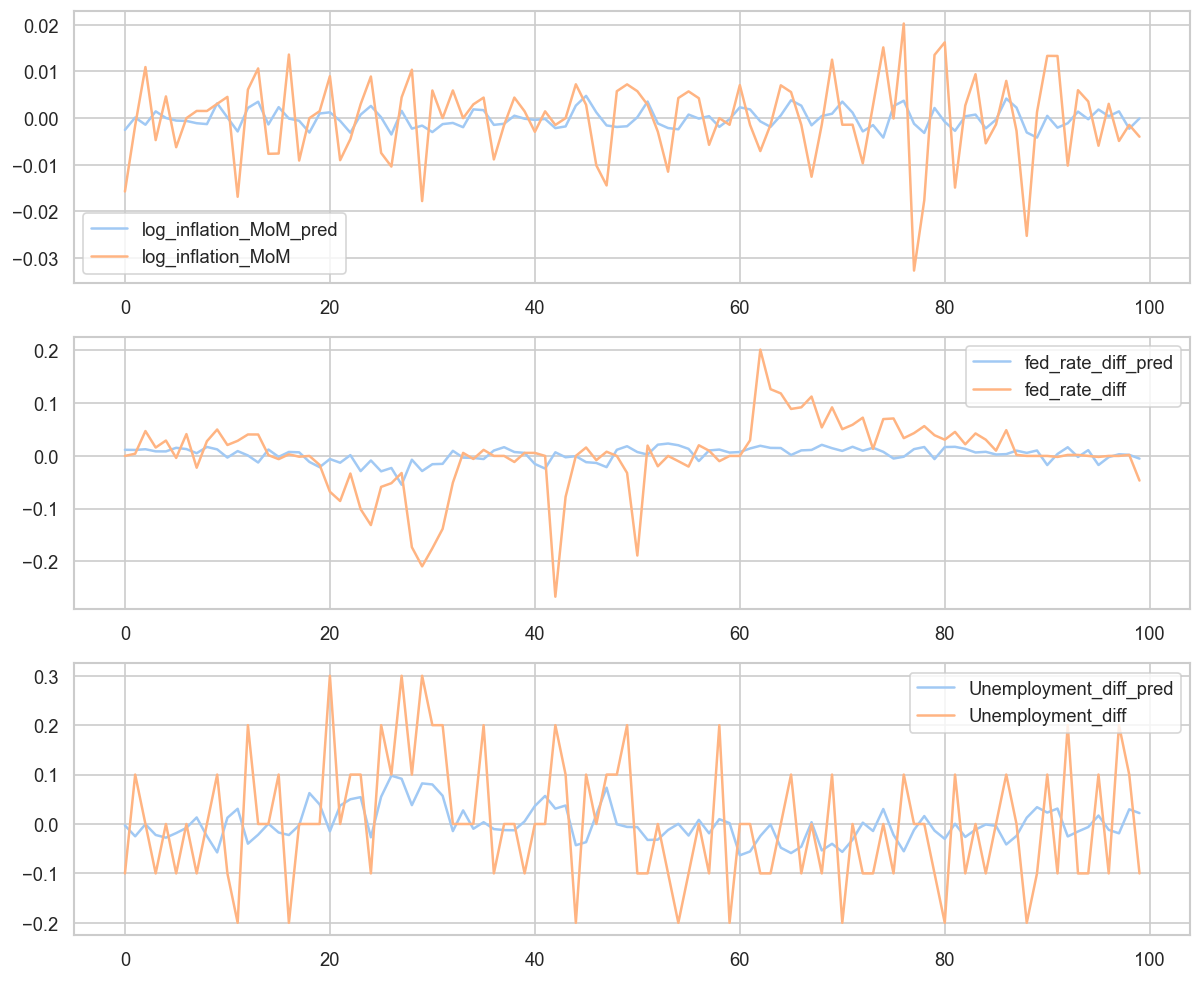

In [84]:
plot_predictions(lstm_model, [0,100], validation_dataloader, transform=True)

Text(0.5, 1.0, 'Unemployment_DIFF_pred Residuals')

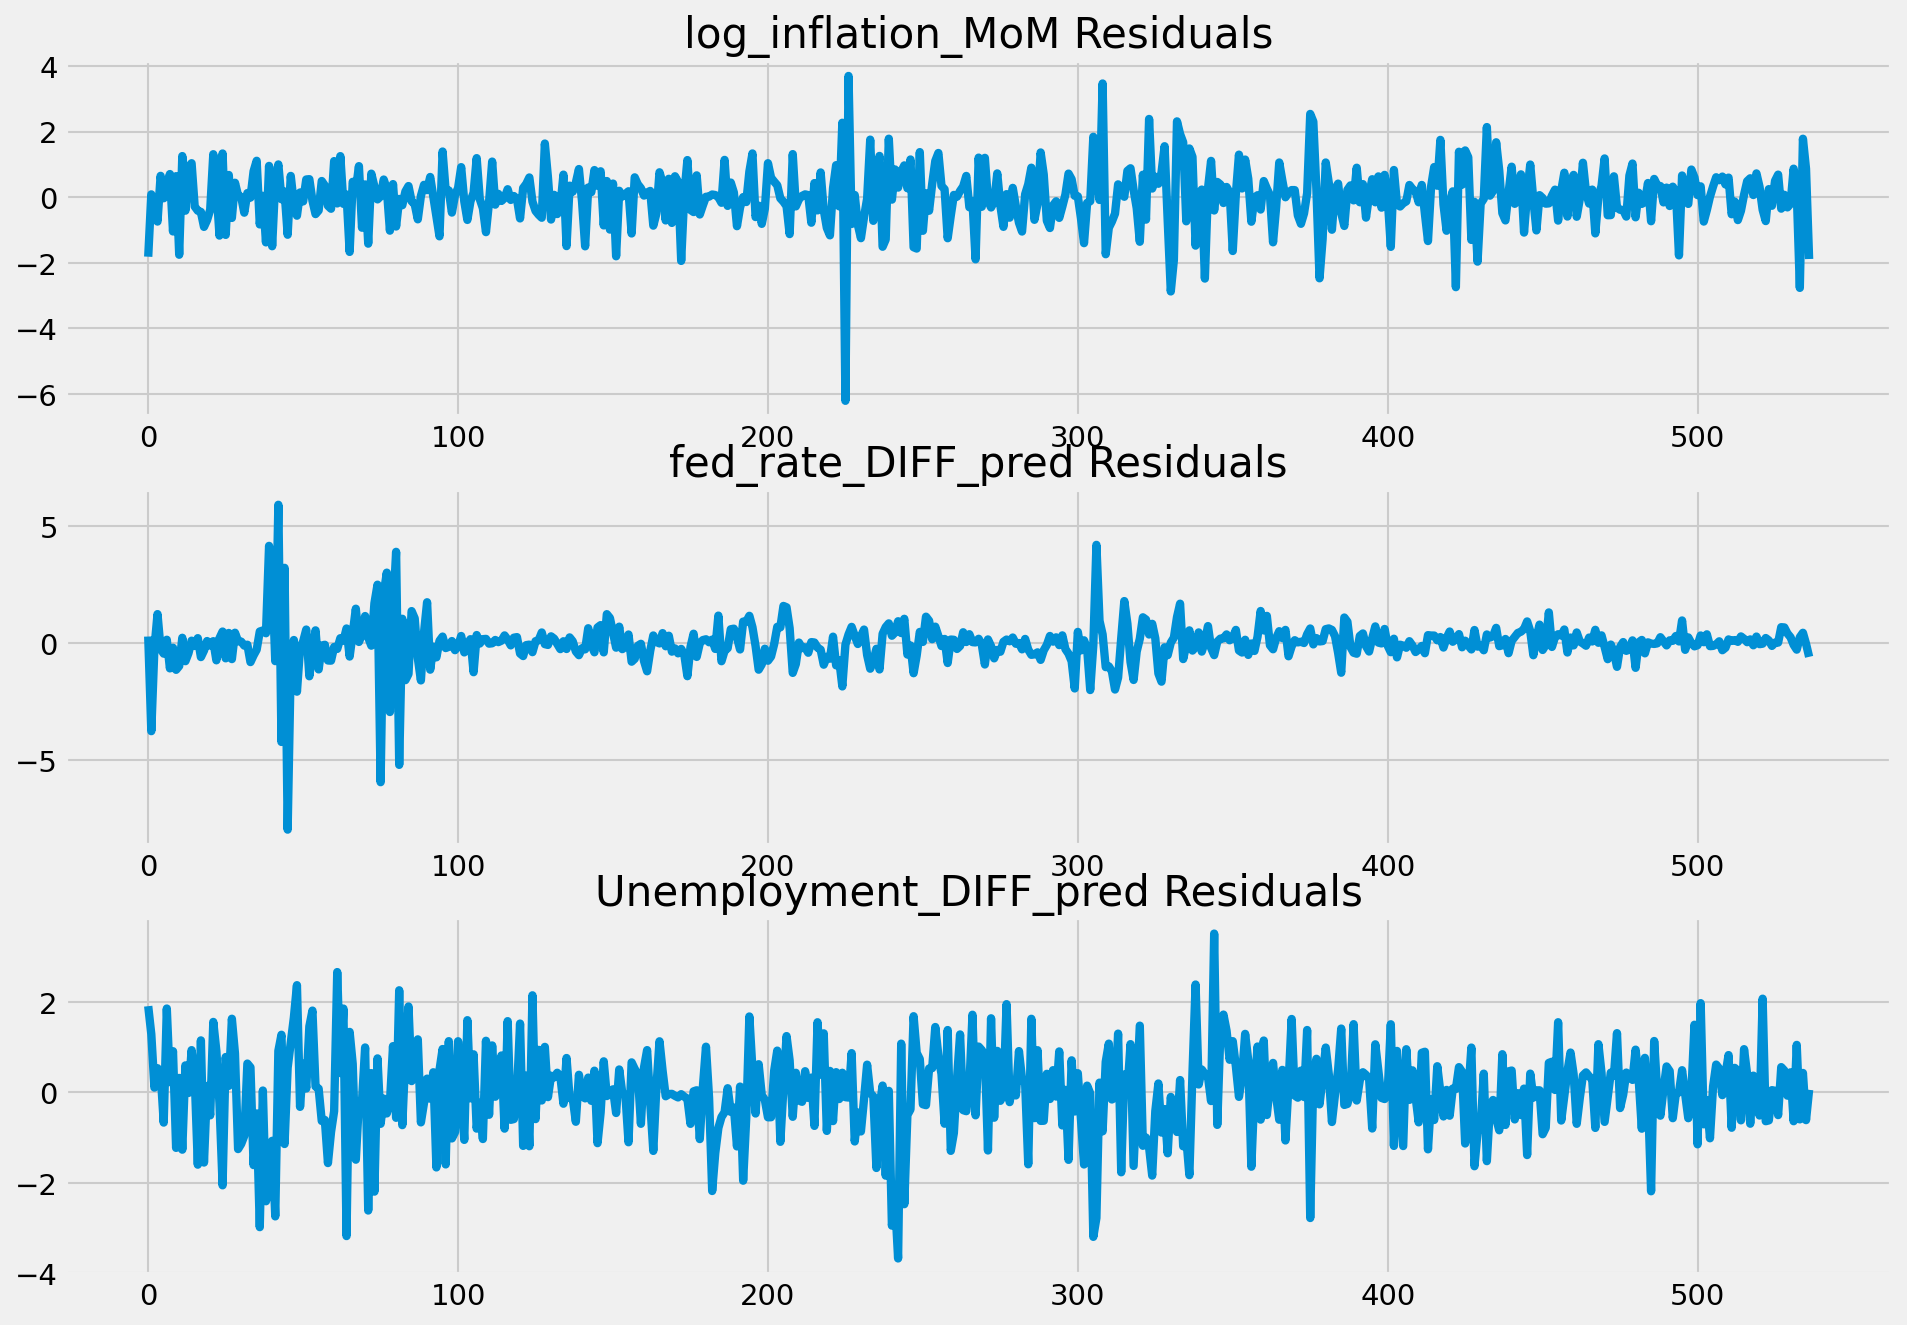

In [44]:
pred, res = get_predictions(lstm_model, train_dataloader,return_residuals=True)
residuals_df = pd.DataFrame(
        res, 
        columns = ["log_inflation_MoM_pred_res", "fed_rate_DIFF_pred_res", "Unemployment_DIFF_pred_res"]
    )

fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))

residuals_df["log_inflation_MoM_pred_res"].plot(ax=axs[0])
residuals_df["fed_rate_DIFF_pred_res"].plot(ax=axs[1])
residuals_df["Unemployment_DIFF_pred_res"].plot(ax=axs[2])
axs[0].set_title("log_inflation_MoM Residuals")
axs[1].set_title("fed_rate_DIFF_pred Residuals")
axs[2].set_title("Unemployment_DIFF_pred Residuals")

In [49]:
# Get the run
experiment_id = mlflow.get_experiment_by_name("LSTM_training").experiment_id
run = mlflow.search_runs(experiment_id, filter_string="params.scaling='standard'").iloc[0]
run_id = run.run_id

first_version = mlflow.register_model(
    f"runs:/{run_id}/best_model", "LSTMModel"
).version
first_version

Successfully registered model 'LSTMModel'.
Created version '1' of model 'LSTMModel'.


1

### Tune some Hyperparameters

In [87]:
from optuna.trial import Trial
def objective(trial:Trial):
    params = {
        "hidden_size": trial.suggest_float("hidden_size", 10, 16, step=2),
        "seq_length" : trial.suggest_float("seq_length", 1, 12, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 0.000001, 0.001)
        
    }

    train_dataloader, validation, test_dataloader, full_data_loader, lambda_ = get_data_loaders(
        cutoff_date, validation_cutoff_date, int(params["seq_length"]), transform=True
    )
    
    lstm = LSTM(3, int(params["hidden_size"])).to(device)
    lstm_model = RNN(lstm, "LSTM", 120, train_dataloader, validation_dataloader, 
                     learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)
    lstm_model.train()
    
    loss = lstm_model.best_validation_loss

    return loss

In [ ]:
from optuna.samplers import TPESampler
import optuna

study = optuna.create_study(direction = "minimize", sampler =TPESampler())
study.optimize(objective, n_trials=20)

In [789]:
print(study.best_params)
print(study.best_value)

{'hidden_size': 12.0, 'seq_length': 3.0, 'learning_rate': 0.00028731290480097656}
2.0225421876618355


#### Train model with new hyperparameters

In [ ]:
hidden_size = int(study.best_params['hidden_size'])
seq_length = int(study.best_params['seq_length'])
train_dataloader, validation, test_dataloader, full_data_loader, lamba_ = get_data_loaders(cutoff_date, validation_cutoff_date, seq_length, transform=True)

lstm = LSTM(3, hidden_size).to(device)
lstm_model = RNN(lstm, "LSTM", 120, train_dataloader, validation_dataloader, 
                 learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)

mlflow.set_experiment('LSTM_training')
# Train LSTM
lstm_model.train()

#### Register Optim|ized model

In [50]:
# Register optimized model
run = mlflow.search_runs(experiment_id, filter_string="params.scaling='standard'").iloc[0]
run_id = run.run_id
second_version = mlflow.register_model(
    f"runs:/{run_id}/best_model", "LSTMModel"
).version
print(second_version)
client = mlflow.MlflowClient()
client.set_registered_model_alias("LSTMModel", "staging", second_version)

2


Registered model 'LSTMModel' already exists. Creating a new version of this model...
Created version '2' of model 'LSTMModel'.


In [51]:
# Register scaler
client = mlflow.MlflowClient()

version = mlflow.register_model(
    f"runs:/{run_id}/scaler", "standardscaler"
).version

client.set_registered_model_alias("standardscaler", "production", version)

Successfully registered model 'standardscaler'.
Created version '1' of model 'standardscaler'.


# Model Evaluation

In [52]:
def forecast_out_of_sample(model, device, seq_length):
    """ Generates raw forecasts with the PyTorch model

    Parameters
    ----------
    X : torch.tensor
      Latest observed data so the model can forecast into the future.

    Returns
    -------
    torch.tensor
    """
    first_data = test_dataloader.dataset.data[-seq_length:, :].to(device)
    forecasts = []
    outputs = []
    for i in range(len(test_dataloader.dataset.data)):
        out = model.predict(first_data)
        new_value = torch.concat(
            [
                first_data[-(seq_length+1):].unsqueeze(dim=0), 
                out[-1].reshape(1,1,3)
            ], 
            dim=1
        )[:, 1:, :]
        
        forecasts.append(new_value[:, -1, :].unsqueeze(dim=0))
        outputs.append(new_value)
        first_data = outputs[-1].squeeze(dim=0)
    return torch.concat(forecasts, dim=1).to(device)

In [46]:
def calculate_performance_metrics(forecasts, dataloader, device):
    """ Calculates the mean squared error and mean absolute error.
    """
    mse_ = mse(forecasts.squeeze(), dataloader.dataset.data.to(device)).item()
    mae_ = mean_absolute_error(forecasts.squeeze().cpu(), test_dataloader.dataset.data.cpu())
    return mse_, mae_

In [62]:
# test LSTM with params 'hidden_size': 12.0, 'seq_length': 3.0, 'learning_rate': 0.0001
# Set first model to staging and test
# version = second_version
# client.set_registered_model_alias("LSTMModel", "staging", version)
# model = mlflow.pytorch.load_model(
#             model_uri = "models:/LSTMModel@staging"
#         )

#lstm_model.set_model(model)
forecasts = forecast_out_of_sample(lstm_model, device, 3)

mse_, mae_ = calculate_performance_metrics(forecasts, test_dataloader, device)
print("MSE:", mse_)
print("MAE:", mae_)

MSE: 9.21732781928384
MAE: 1.0831111319332765


In [113]:
def create_production_model(run, retrain=False):
    _, _, _, full_data_loader, lamba_ = get_data_loaders(
        cutoff_date, validation_cutoff_date, seq_length=int(run["params.sequence length"]), transform=True,
    )

    if retrain:
        if run["params.gradient clipping"] == "None":
            grad_clipping = None
        
        lstm_prod = LSTM(3, int(run["params.hidden size"])).to(device)
        rnn_prod = RNN(
            rnn=lstm_prod,
            model_name="LSTMprod",
            n_epoch=int(run["params.epochs"]),
            learning_rate=float(run["params.learning_rate"]),
            train_loader=full_dataloader,
            gradient_clipping=grad_clipping,
            device=device,
        )
        rnn_prod.train()
        
    experiment_id = mlflow.get_experiment_by_name("LSTM_training").experiment_id
    run = mlflow.search_runs(experiment_id, filter_string="params.scaling='standard'").iloc[2]
    run_id = run.run_id
    
    version = mlflow.register_model(
        f"runs:/{run_id}/best_model", "LSTMProduction"
    ).version
    client.set_registered_model_alias("LSTMProduction", "production", version)

In [114]:
# Let model procede if performance is satisfactory
if mse_ < 9.31 and mae_ < 1.11:
    create_production_model(run)

Successfully registered model 'LSTMProduction'.
2024/09/03 15:37:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTMProduction, version 1
Created version '1' of model 'LSTMProduction'.


## Forecasts

In [115]:
def generate_latest_prediction(model, seq_length):
    most_recent = data_diff.iloc[-2:][["CPI", "fed_rate", "Unemployment"]]
    yr_ago_cpi = data_diff.iloc[[-12]][["CPI"]]

    # Log transform data so we can add the forecasts to them
    most_recent_logs = most_recent.copy()
    most_recent_logs["CPI"] = boxcox(most_recent_logs["CPI"], lmbda= lambda_)[0]
    most_recent_logs["fed_rate"] = np.log(most_recent_logs["fed_rate"])

    data = full_dataloader.dataset.data[-seq_length:, :].unsqueeze(dim=0)

    # Untransform forecasts and add them to the latest observation 
    # since the model forecasts the change in the variables.
    print("untransformed:\n", model.predict(data).cpu().numpy())
    prediction = scaler.inverse_transform(
        model.predict(data).cpu().numpy()
    )
    print("prediction:\n", prediction)
    prediction = prediction + (most_recent_logs.iloc[[-1],:].mul({"CPI": 2, "fed_rate":1,"Unemployment":1}) 
                               - [most_recent_logs.iloc[-2]["CPI"].item(), 0, 0])
    prediction.index = [most_recent_logs.index[-1] + pd.DateOffset(months=1)]
    
    # undo logs
    prediction["CPI"] =(prediction["CPI"]*(lambda_) + 1)**(1/lambda_)
    prediction["fed_rate"] = np.exp(prediction["fed_rate"])
    print(prediction["fed_rate"])
    return prediction


def round_predictions(predictions):
    predictions["fed_rate"] = round(predictions["fed_rate"], 2)
    predictions["CPI"] = round(predictions["CPI"], 3)
    predictions["Unemployment"] = round(predictions["Unemployment"], 1)


def calculate_inflation(predictions, mode="both"):
    most_recent = data_diff.iloc[[-1]][["CPI", "fed_rate", "Unemployment"]]
    yr_ago_cpi = data_diff.iloc[[-12]][["CPI"]]
    # MoM  inflation
    inflation_mom = ((predictions["CPI"].item() - most_recent["CPI"].item()) 
                     / most_recent["CPI"].item())*100
    # YoY Inflation
    inflation_yoy = ((predictions["CPI"].item() - yr_ago_cpi["CPI"].item()) 
                     / yr_ago_cpi["CPI"].item())*100
    if mode == "yoy":
        return inflation_yoy
    elif mode == "mom":
        return inflation_mom
    else:
        return inflation_mom, inflation_yoy

month = (data_diff.iloc[[-1]].index + pd.DateOffset(months=1))\
    .strftime("%B").item()


In [ ]:
# Look at some forecasts
model_name = "LSTMProduction@production"
model = mlflow.pytorch.load_model(
            model_uri = f"models:/{model_name}"
        )
lstm_model.set_model(model)

prediction = generate_latest_prediction(lstm_model, 3)
#round_predictions(prediction)
prediction_month = prediction.index.get_level_values(0).strftime("%B").item()
prediction["fed_rate"] = round(prediction["fed_rate"], 2)

print(f"{month} forecasts:\n", prediction)
inflation_mom, inflation_yoy = calculate_inflation(prediction)
print(f"MoM inflation rate: {inflation_mom}%")
print(f"YoY inflation rate: {inflation_yoy}%")

2024/09/03 15:37:57 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


untransformed:
 [[-0.56342113 -0.13462311  0.15948623]]
prediction:
 [[-0.00292906 -0.01033551  0.02885485]]
2024-08-01    5.275195
Name: fed_rate, dtype: float64
August forecasts:
                    CPI  fed_rate  Unemployment
2024-08-01  312.735887      5.28      4.328855
MoM inflation rate: -0.2545540167384708%
YoY inflation rate: 2.1388519464115663%


In [ ]:
lstm = LSTM(3, 12)
print("Num parameters:",sum(p.numel() for p in lstm.parameters()))

# Bayesian Neural Network via Variational Inference

We want to estimate:

$$p_{\theta}(\mathbf{w}| D) = \frac{p_{\theta}(D|\mathbf{w})p_{\theta}(\mathbf{w})}{\int p_{\theta}(D, \mathbf{w})d\mathbf{w}}$$

Which is often intractable, especially for non-linear models such as BNNs

We introduce a simpler distribution $q_{\phi}$ which is parametarized by $\phi$ and notice:

\begin{align}
    \log{p_{\theta}(D)} &= \log{\int p_{\theta}(D, \mathbf{w})d\mathbf{w}}\\
    &=\log{\int \frac{p_{\theta}(D, \mathbf{w})q_{\phi}(\mathbf{w})}{q_{\phi}(\mathbf{w})} d\mathbf{w}}\\
    &= \log{\mathbb{E}_ {q_{\phi}} \left[ \frac{p_{\theta}(D, \mathbf{w})}{q_{\phi}(\mathbf{w})} \right]}\\
    &\ge \int \log{\frac{p_{\theta}(D, \mathbf{w})}{q_{\phi}(\mathbf{w})}q_{\phi}(\mathbf{w}) d\mathbf{w}} \hspace{1cm}(\text{Jensen's Inequality})\\
    &= \mathbb{E}_ {q_{\phi}} \left[ \log p_{\theta}(D, \mathbf{w}) - \log q_{\phi}(\mathbf{w})\right] \\
    &= \mathbb{E}_ {q_{\phi}} \left[ \log p_{\theta}(D)\right]  - \text{KL}(q_{\phi}(\mathbf{w}) || p_{\theta}(\mathbf{w}|D))

\end{align}

This result is called the evidence lower bound. When we maximize this we will be minimizing the KL-divergence so that $q_{\phi}(\mathbf{w})$ is is close to the true posterior $p_{\theta}(\mathbf{w}|D)$

In [ ]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

In [20]:
pyro.__version__

'1.9.1'

In [15]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean, AutoNormal, AutoDiagonalNormal

def train_bayesian_lstm(model, train_loader, num_epochs=10, lr=0.01):
    pyro.clear_param_store()
    guide = AutoNormal(model, init_loc_fn=init_to_mean).to(device)
    svi = pyro.infer.SVI(model, guide, pyro.optim.Adam({"lr": lr}), loss=pyro.infer.Trace_ELBO())

    for epoch in range(num_epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)
            loss = svi.step(x_batch, y_batch)
            total_loss += loss
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")
    return guide


In [24]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal, init_to_mean

class BayesianLSTM(PyroModule):
    def __init__(self, input_dim, hidden_dim, output_dim, device, 
                 num_layers=1, weight_prior_noise=1.0, bias_prior_noise=10.0):
        super().__init__()
        self.device = device

        self.lstm = PyroModule[nn.LSTM](input_dim, hidden_dim, num_layers=num_layers, batch_first=True).to(self.device)

        param_names = list(self.lstm._parameters.keys())
        for name in param_names:
            param = self.lstm._parameters[name].to(self.device)
            prior_noise = weight_prior_noise if "bias" in name else bias_prior_noise
            prior = dist.Normal(
                torch.tensor(0.0, device=self.device), 
                torch.tensor(prior_noise, device=self.device)).expand(param.shape).to_event(param.dim())
            setattr(self.lstm, name, PyroSample(prior))
         

        self.fc = PyroModule[nn.Linear](hidden_dim, output_dim).to(device)
        self.fc.weight = PyroSample(
            dist.Normal(torch.tensor(0.0, device=self.device), torch.tensor(weight_prior_noise, device=self.device))\
                .expand(self.fc.weight.to(device).shape).to_event(2)
        )
        self.fc.bias = PyroSample(
            dist.Normal(torch.tensor(0.0, device=self.device), torch.tensor(bias_prior_noise, device=self.device))\
            .expand(self.fc.bias.to(device).shape).to_event(1)
        )

    def forward(self, x, y=None):
        x = x.to(self.device)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        
        dim = 3
        std = pyro.sample(
            "obs_scale", dist.LogNormal(torch.zeros(dim, device=device), torch.tensor(0.1,device=self.device)).to_event(1)
        )
        corr = pyro.sample("obs_corr", dist.LKJCholesky(dim, torch.ones((),device=self.device)))
        obs_scale_tril = std.unsqueeze(-1) * corr
        
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.MultivariateNormal(out, scale_tril=obs_scale_tril), obs=y)
        return out

In [ ]:
model = BayesianLSTM(3,12,3, weight_prior_noise=0.001, device=device).to(device)
aprox = train_bayesian_lstm(model, train_dataloader, num_epochs=20, lr=0.001)

In [616]:
from pyro.infer import Predictive
post_predictive = Predictive(model, guide=aprox, num_samples=200).to(device)
loss = nn.MSELoss()
losses = []
for idx, (x, y) in enumerate(validation_dataloader):
    x = x.to(device).float().to(device)
    y = y.to(device).float().to(device)
    
    out = post_predictive(x)['obs'].mean(dim=0)
    loss_val = loss(out, y)
    losses.append(loss_val.item())
        
avg_loss = np.mean(losses)

In [617]:
avg_loss

2.1788655870101032

In [25]:
from torch import optim
import torch.nn as nn
from pyro.infer import Predictive
class BayesianTrainer:
    def __init__(self, net, model_name, n_epoch:int, 
                 train_loader, validation_loader=None, 
                 learning_rate:float=0.0001,
                 device = None, train_data_end_date = None,
                ):
        """ Trainer for the rnn.
        
        Parameters
        ----------
        net : torch.nn.Module
            PyTorch model to be trained
        model_name : str
            name of the model that will be saved models folder
        n_epoch : int
            number of epochs for training
        train_loader : DataLoader
        validation_loader : DataLoader
        learning_rate : float
        device: str
            Device used for training
        train_data_end_date: str
            The date where the train data ends
        """
        self.n_epoch, self.lr = n_epoch, learning_rate

        self.train_loader, self.validation_loader = train_loader, validation_loader
        
        self.net = net
        self.model_name = model_name

        # Mean squared error loss
        self.loss = nn.MSELoss()

        

        self.best_validation_loss = 1000000 # arbritrary large number just to initialize
        self.best_model = None
        self.device = device

        self.guide = AutoDiagonalNormal(self.net, init_loc_fn=init_to_mean, init_scale=0.01).to(self.device)
        
        # Keep track of date when the train set ends
        self.train_data_end_date = train_data_end_date

        
    def train(self):
        with mlflow.start_run() as run:
            self.run = run
            pyro.clear_param_store()
            svi = pyro.infer.SVI(self.net, self.guide, pyro.optim.Adam({"lr": self.lr}), loss=pyro.infer.Trace_ELBO())
            
            self.train_error = []
            self.val_error = []
            for epoch in range(1, self.n_epoch + 1):
                self.train_loop(epoch, svi)
                if self.validation_loader:
                    self.validation(epoch)
            
            
            if self.validation_loader:
                print("Saving best model with lowest validation mse loss = {}".format(self.best_validation_loss)) 
                mlflow.log_metric("Best-validation-loss", self.best_validation_loss)
            else:
                torch.save(self.net, model_folder / f"{self.model_name}.pt")
            
        
        
    def train_loop(self, epoch, svi):
        self.net.train()
        total_loss = 0
        total_mse_loss = 0

        post_predictive = Predictive(self.net, guide=self.guide, num_samples=100).to(self.device)

        for x_batch, y_batch in self.train_loader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)
            loss = svi.step(x_batch, y_batch)
            
            out = post_predictive(x_batch)['obs'].mean(dim=0)
            mse_loss = self.loss(out, y_batch)
            total_loss += loss
            total_mse_loss += mse_loss

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(self.train_loader)}")
        print(f"Epoch {epoch+1}, MSE Loss: {total_mse_loss / len(self.train_loader)}")
        
        self.train_error.append(total_loss)
        #print("Epoch {} average train loss: {:.6f}".format(epoch, avg_loss))
        

    
    def validation(self, epoch):
        """
        Test model on validation data
        """
        post_predictive = Predictive(self.net, guide=self.guide, num_samples=50).to(self.device)
        losses = []
        
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(self.device).float()
            y = y.to(self.device).float()
            
            self.net.eval()
            with torch.no_grad():
                validation_output = post_predictive(x)['obs'].mean(dim=0)
                loss_val = self.loss(validation_output, y)
                losses.append(loss_val.item())
                
        avg_loss = np.mean(losses)

        # Track the best model and validation loss
        if avg_loss < self.best_validation_loss:
            self.best_validation_loss = avg_loss
            self.save_model()
            
        self.val_error.append(avg_loss)
        print("Epoch {} average validation loss: {:.6f}".format(epoch, avg_loss))


    def save_model(self):
        torch.save({
            "model_state_dict": self.net.state_dict(),
            "guide_state_dict": self.guide.state_dict(),
            "pyro_params": pyro.get_param_store().get_state()
        }, f"{self.model_name}.pt")

    
    def load_model(self, filename="pyro_model.pt"):
        checkpoint = torch.load(filename, weights_only=False)

        # Run a sample through the guide to initialize parameters
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(self.device).float()
            y = y.to(self.device).float()
            self.guide(x, y)
            break

        
        self.net.load_state_dict(checkpoint["model_state_dict"])
        self.guide.load_state_dict(checkpoint["guide_state_dict"])
        pyro.get_param_store().set_state(checkpoint["pyro_params"])
    

    def log_params(self):
        """
        Logging model parameters with MLflow
        """
        mlflow.log_params(
            {
                "batch size": batch_size,
                "epochs": self.n_epoch,
                "sequence length": seq_length,
                "learning_rate": self.lr,
                "hidden size": self.net.hidden_size,
                "Train data end": self.train_data_end_date,
                "Train data size": len(train_dataloader.dataset),
                "Validation data size": len(test_dataloader.dataset),
                "scaling": scaling_mode,
            }
        )
 

    def log_model_weights(self, epoch):
        """
        Logs the models parameters ever couple of epochs.
        """
        if epoch % 10 == 0:
            with torch.no_grad():
                for i, param in enumerate(self.net.parameters()):
                    p = param.cpu().numpy()
                    df = pd.DataFrame(p)
                    df.to_csv(f"./params/params_{i}.csv")
                mlflow.log_artifacts("./params", f"./params/{epoch}")


    def log_model(self):
        """
        Uses MLflow to log the best model in pytorch flavour
        """
               
        best_model = torch.load(model_folder / f"{self.model_name}.pt")
        best_model.eval()
        mlflow.pytorch.log_model(best_model, "best_model")
        mlflow.sklearn.log_model(scaler, "scaler")


    def log_loss(self):
        """
        Logging train and validation performance with MLflow
        """
        log_every = 10
        for epoch, val in enumerate(self.train_error):
            if epoch % log_every == 0:
                mlflow.log_metric(f"train mean loss", val, step=epoch)
        if self.validation_loader:
            for epoch, val in enumerate(self.val_error):
                if epoch % log_every == 0:
                    mlflow.log_metric(f"val-loss", val, step=epoch)

    
    def predict(self, x:torch.tensor, alpha=0.05, n_samples=100):
        """
        Generate a prediction with the model. 
        Each output contains predictions for inflation, unemployment, and Fed rate.
        input:
            x: tensor size [n_samples, 3]
        returns:
            torch.tensor: size [n_samples, 3]
        """
        post_predictive = Predictive(self.net, guide=self.guide, num_samples=n_samples).to(self.device)
        out = post_predictive(x)
        out= out['obs']
        mean_prediction = out.mean(dim=0)
        
        numpy_out = out.cpu().numpy()
        lower = np.percentile(numpy_out, ((alpha)/2)*100, axis=0)
        
        upper = np.percentile(numpy_out, (1-alpha/2)*100, axis=0)
        
        return mean_prediction, (torch.tensor(lower, device=device), torch.tensor(upper, device=device))
        
            

    def set_model(self, model):
        self.net = model

In [26]:
trainer2 = BayesianTrainer(
    net=BayesianLSTM(3,12,3, weight_prior_noise=10, bias_prior_noise=10, device=device).to(device),
    model_name="BayesLSTM",
    n_epoch=20,
    train_loader=train_dataloader,
    validation_loader=validation_dataloader,
    learning_rate = 0.001,
    device=device
)

In [ ]:
trainer2.train()

In [27]:
trainer2.load_model("BayesLSTM.pt")

In [28]:
uppers = []
lowers = []
means = []
for idx, (x, y) in enumerate(validation_dataloader):
    x = x.to(device).float()
    y = y.to(device).float()
    
    mean, interval = trainer2.predict(x, n_samples=200)
    
    upper, lower = interval
    uppers.append(upper)
    lowers.append(lower)
    means.append(mean)
    
    

In [31]:
uppers = torch.concat(uppers)
lowers = torch.concat(lowers)
means = torch.concat(means)

Plot Credible intervals

Text(0.5, 1.0, 'Box-Cox Transformed Inflation DIFF2')

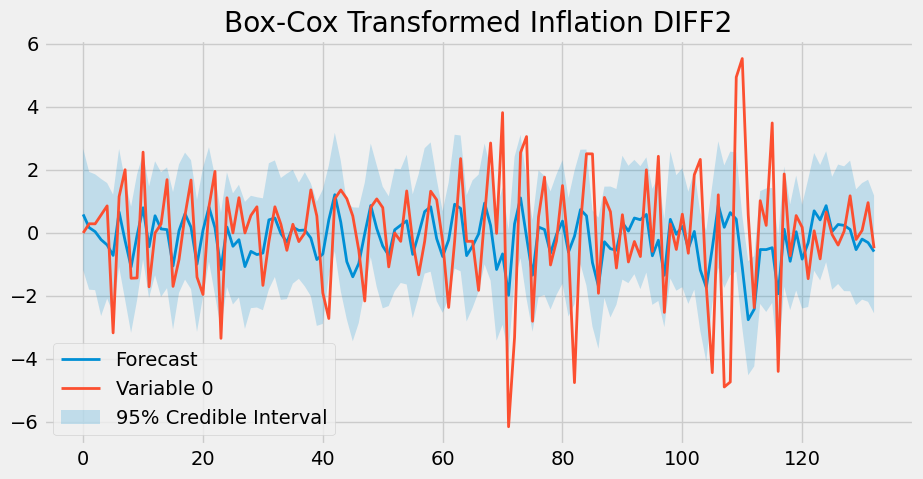

In [34]:
def plot_forecasts(means, upper_intervals, lower_intervals, var=0):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(10,5))
    forecast = means[:,var].cpu().numpy()
    upper = upper_intervals[:,var].cpu().numpy()
    lower = lower_intervals[:,var].cpu().numpy()

    plt.title(f"Variable {var} Forecasts")
    plt.plot(forecast, linewidth=2, label='Forecast')
    plt.plot(validation_dataloader.dataset.data[seq_length:,var], label= f'Variable {var}', linewidth=2)
    plt.fill_between(x=np.arange(len(upper)), y1=upper, y2=lower, alpha=0.2, label="95% Credible Interval")
    plt.legend()

# Inflation
plot_forecasts(means, uppers, lowers, var=0)
plt.title("Box-Cox Transformed Inflation DIFF2")

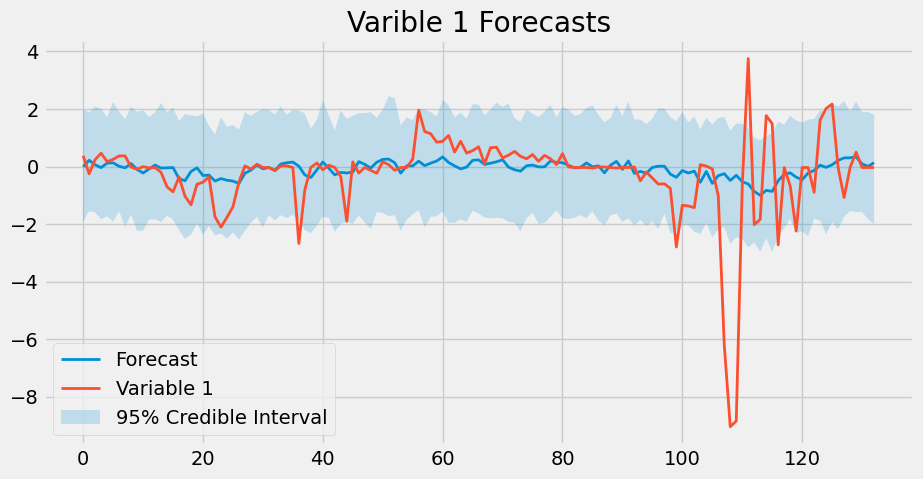

In [ ]:
# Fed Rate
plot_forecasts(means, uppers, lowers, var=1)

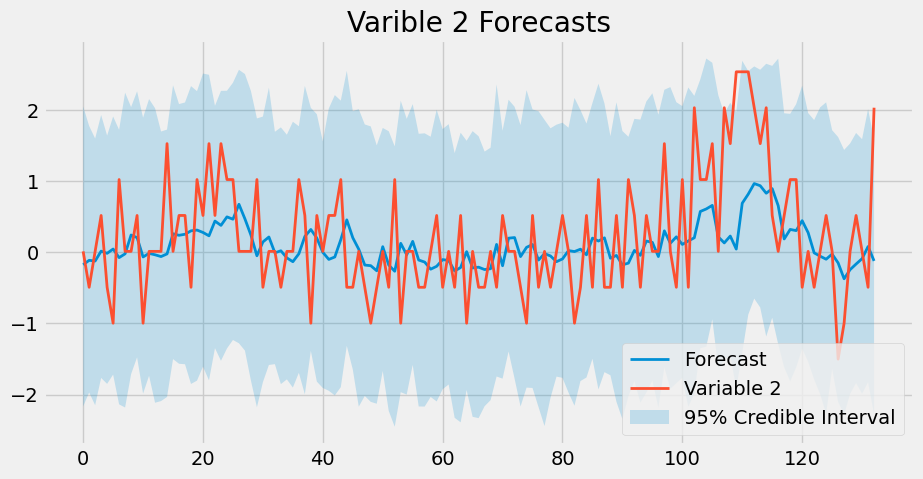

In [ ]:
# Unemployment
plot_forecasts(means, uppers, lowers, var=2)

### Test

In [28]:
loss = nn.MSELoss()
total_loss = 0
for idx, (x, y) in enumerate(test_dataloader):
    x = x.to(device).float()
    y = y.to(device).float()
    
    mean, interval = trainer2.predict(x, n_samples=200)
    batch_loss = loss(mean, y)
    total_loss += batch_loss

print(total_loss/len(test_dataloader))


tensor(385.0073, device='cuda:0')

In [63]:
print(total_loss/len(test_dataloader))


tensor(9.1668, device='cuda:0')
